<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/3.%20TFIM%20VQfixedNHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 14.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

In [2]:
from functools import cache

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

In [3]:
seed_list = [1,   4,   5,   6,   7,   8,  10,  11,  12,  13,
14,  15,  17,  18,  19,  20,  21,  23,  24,  25,
27,  28,  29,  30,  31,  34,  36,  38,  39,  40,
41,  42,  43,  45,  46,  47,  48,  49,  51,  52,
55,  59,  61,  63,  65,  66,  67,  68,  70,  71,
74,  75,  76,  77,  78,  81,  86,  87,  90,  93,
95,  96,  97,  101, 102, 103, 104, 105, 106, 107,
112, 113, 114, 116, 118, 121, 124, 126, 127, 128,
132, 133, 135, 136, 137, 138, 139, 140, 141, 142,
144, 147, 148, 149, 150, 151, 152, 154, 155, 162,
165, 166, 169, 171, 172, 174]

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [4]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [5]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.155367074350501

In [6]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

# VQNHE in Noiseless Simulator

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [7]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

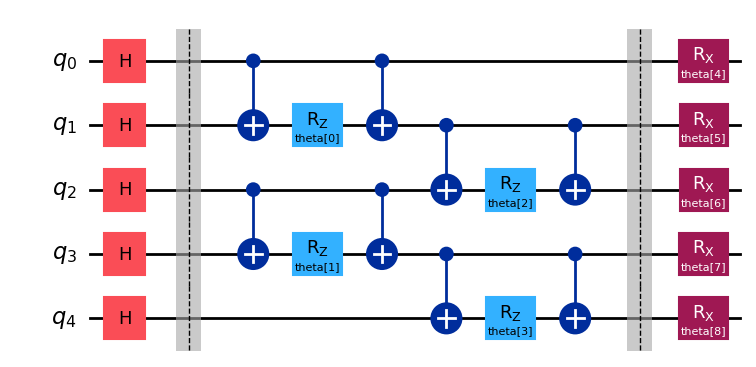

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

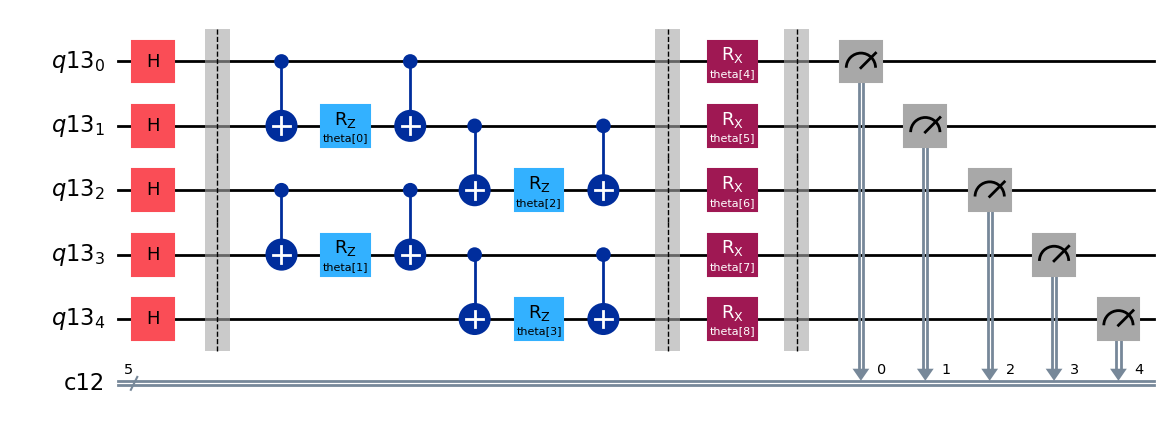

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

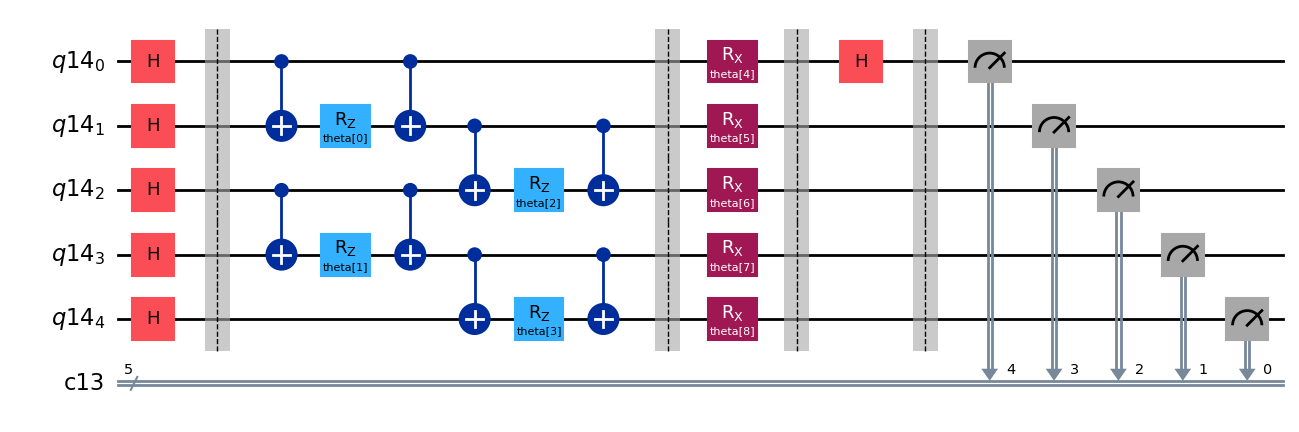

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

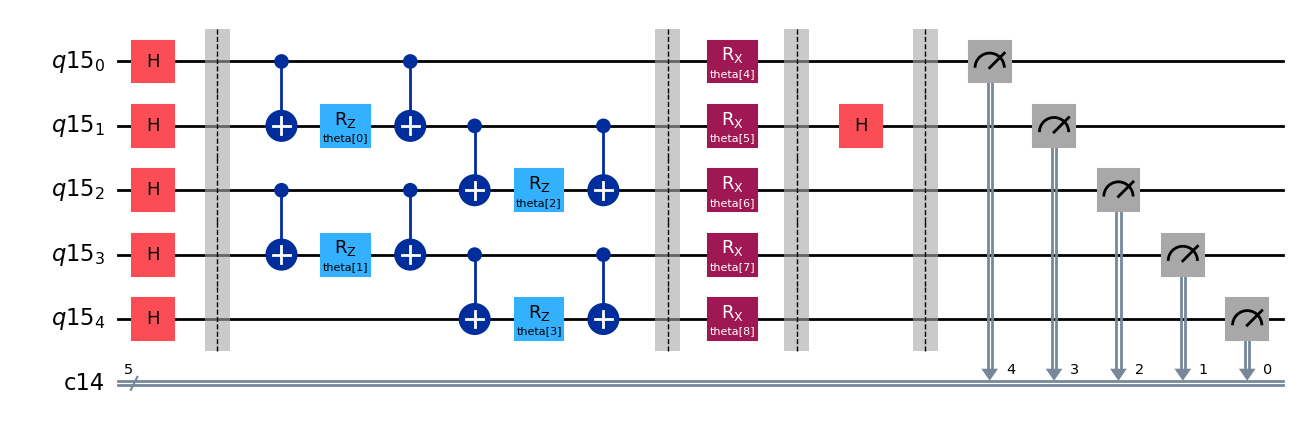

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

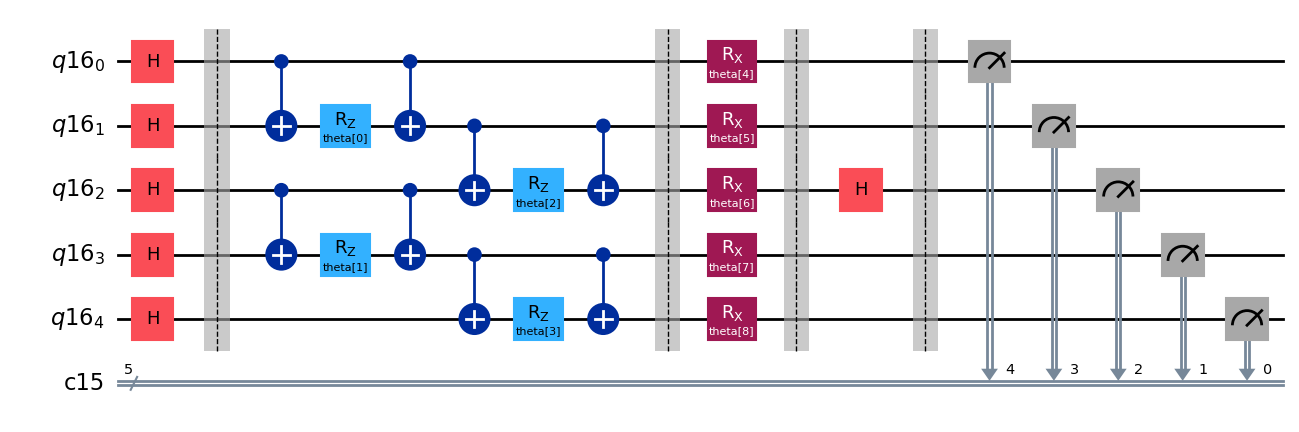

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

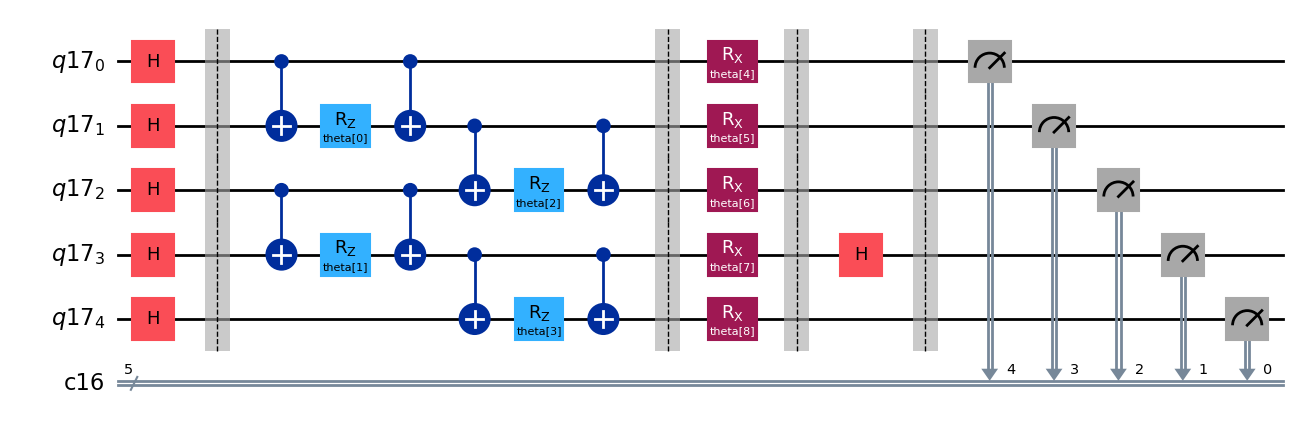

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

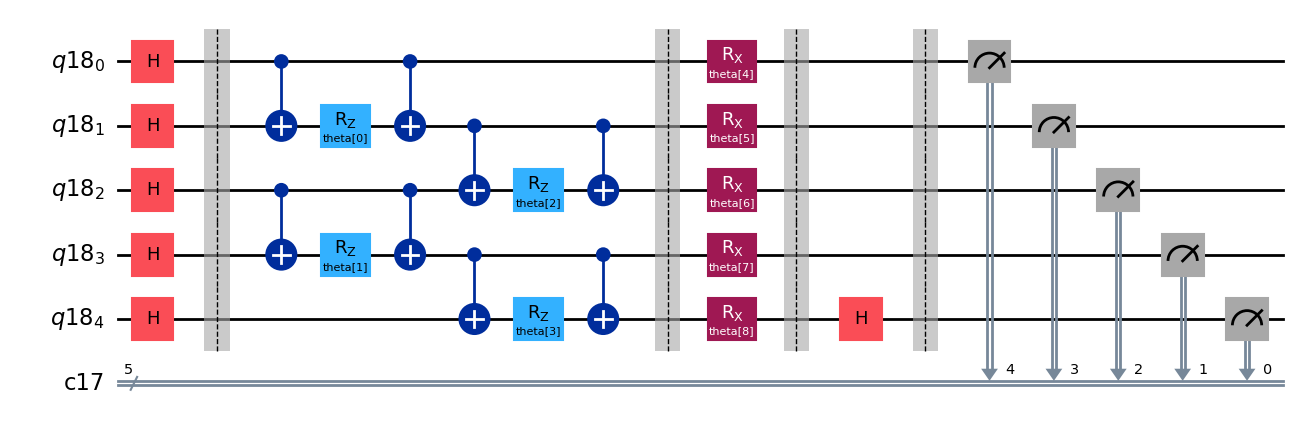

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [ ]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## Cost Function for VQE

In [ ]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [ ]:
def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

## 1st Step : Optimizing Parameters in PQC

In [ ]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(4)
x0 = 2 * np.pi * np.random.random(9)

x0

array([6.07602768, 3.43836163, 6.11155608, 4.49132135, 4.3839595 ,
       1.35773034, 6.13411331, 0.03914585, 1.58953506])

In [ ]:
callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="bfgs",
  callback=callback_vqe,
  options=options
)

Optimization terminated successfully.
         Current function value: -5.897229
         Iterations: 45
         Function evaluations: 570
         Gradient evaluations: 57


In [ ]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5.897229133327293
        x: [ 5.803e+00  5.886e+00  5.886e+00  5.803e+00  7.854e+00
            -1.261e-06  7.854e+00  1.466e-06  1.571e+00]
      nit: 45
      jac: [-1.192e-07 -5.960e-07 -7.153e-07 -1.788e-07  1.192e-07
            -8.345e-07 -7.749e-07  1.192e-07 -5.960e-08]
 hess_inv: [[ 4.821e-01 -8.480e-04 ...  2.708e-02 -3.657e-02]
            [-8.480e-04  4.716e-01 ... -3.784e-02  6.984e-02]
            ...
            [ 2.708e-02 -3.784e-02 ...  6.264e+00 -5.876e+00]
            [-3.657e-02  6.984e-02 ... -5.876e+00  7.924e+00]]
     nfev: 570
     njev: 57

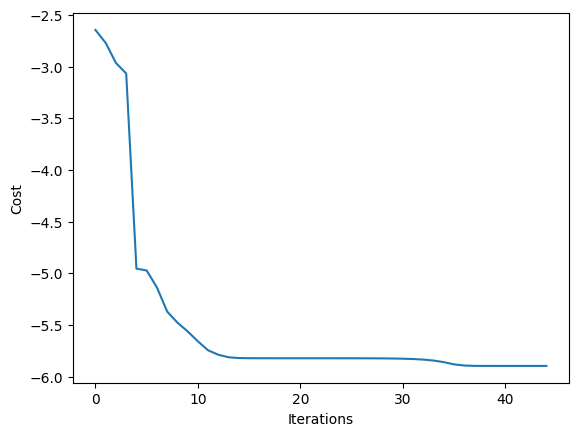

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_vqe["iters"]), callback_dict_vqe["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
params_pqc = res.x
params_pqc

array([ 5.80344510e+00,  5.88570616e+00,  5.88570617e+00,  5.80344509e+00,
        7.85398307e+00, -1.26102966e-06,  7.85398051e+00,  1.46596586e-06,
        1.57079489e+00])

## Cost Function for VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [ ]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [ ]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
def Z0Z1(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [ ]:
def X0(params_nn, ansatz_x0, params_pqc, sampler):
  job = sampler.run(ansatz_x0, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, ansatz_x1, params_pqc, sampler):
  job = sampler.run(ansatz_x1, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, ansatz_x2, params_pqc, sampler):
  job = sampler.run(ansatz_x2, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, ansatz_x3, params_pqc, sampler):
  job = sampler.run(ansatz_x3, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, ansatz_x4, params_pqc, sampler):
  job = sampler.run(ansatz_x4, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [ ]:
def norm(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc).result()
  prob_string = job.quasi_dists[0]

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler):
  expval = 0
  expval = expval + Z0Z1(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z1Z2(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z2Z3(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z3Z4(params_nn, ansatz_zz, params_pqc, sampler)

  expval = expval - X0(params_nn, ansatz_x0, params_pqc, sampler)
  expval = expval - X1(params_nn, ansatz_x1, params_pqc, sampler)
  expval = expval - X2(params_nn, ansatz_x2, params_pqc, sampler)
  expval = expval - X3(params_nn, ansatz_x3, params_pqc, sampler)
  expval = expval - X4(params_nn, ansatz_x4, params_pqc, sampler)

  expval = expval / norm(params_nn, ansatz_zz, params_pqc, sampler)

  return expval

In [ ]:
cost_func_vqnhe(np.zeros(shape=271), params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

-5.897229133327298

In [ ]:
def build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## 2nd Step : Opmitizing Parameters in NN

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [ ]:
def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [ ]:
def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Repeat Optimizing Parameters in NN for 100 times

np.random.seed(k)

k 0~100

In [ ]:
local_minimum_list = []

for k in range(100):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x_pqc_0 = 2*np.pi*np.random.random(9)

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 250
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 162
         Function evaluations: 47872
         Gradient evaluations: 176
Optimization terminated successfully.
         Current function value: -6.026674
         Iterations: 117
         Function evaluations: 34816
         Gradient evaluations: 128


In [ ]:
local_minimum_list

## Optimized Parameters

In [ ]:
# PQC optimized parameter

op_param_pqc = np.array([ 5.80341424e+00,  5.88567382e+00,  6.68073582e+00,  5.80344341e+00,
        4.71452869e+00,  3.13939431e+00,  7.85619779e+00, -2.12129562e-03,
        1.57296580e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([-9.50863418e-01,  7.79899725e-02,  7.02867952e-01, -3.80272172e-01,
        5.11024646e-01,  6.96638808e-01,  4.51210989e-02,  8.12588463e-01,
        1.13930864e+00, -6.13227232e-01, -1.08269609e+00, -1.78306348e-02,
       -6.93574331e-01,  9.19452683e-01, -4.99815510e-02,  2.87460393e-01,
       -1.06066202e-01,  4.63964331e-01,  1.24180842e+00, -1.51679910e-01,
       -6.65075105e-01, -2.58720554e-01,  1.69291662e-01, -2.53742942e-01,
        8.40616898e-01,  5.09111139e-01, -9.78605967e-01, -5.77680911e-01,
       -1.34731565e-01, -3.67089431e-01, -6.12570856e-02, -1.13443771e+00,
        7.39235205e-01, -9.51609223e-01,  1.17646017e+00, -4.18339877e-01,
       -5.27549064e-01, -6.30168944e-01, -7.25566274e-01, -3.38109749e-02,
        3.83165832e-01,  3.98686355e-01, -3.30950011e-01,  6.22848238e-01,
        8.72745546e-01,  4.95830155e-02, -1.03719679e+00, -2.81955843e-02,
        6.84570089e-01, -3.15427858e-02,  4.22869802e-01,  4.24296044e-01,
       -6.79560186e-01, -9.66055715e-01,  7.13048994e-01,  9.89449508e-02,
       -8.48276992e-01,  7.68851429e-02, -4.65130766e-01,  9.50302066e-01,
       -4.47868079e-01,  3.09240643e-01, -5.54879154e-01, -7.48112364e-01,
       -2.00352151e-01,  8.48279217e-01,  8.95436722e-01, -7.54519892e-01,
       -5.28986325e-01, -7.82572163e-01,  8.58328349e-01, -1.54703335e-05,
        7.92772622e-01, -7.22647903e-01,  5.98417470e-01,  2.30410600e-01,
       -4.19852716e-01, -6.15438268e-01, -5.35937102e-01,  5.63728140e-01,
        1.06910000e+00,  4.32223252e-01,  4.36750285e-01, -2.42659053e-01,
        5.54929234e-01, -1.83404471e-01, -9.29453198e-01,  4.54104639e-01,
        6.69319928e-01,  7.78969603e-01,  5.59939300e-01, -4.05705118e-01,
        8.77711063e-01,  5.32954478e-01,  5.95477008e-01,  7.17154062e-02,
        5.10122896e-01,  5.06823222e-01,  7.03178023e-01, -9.27906999e-01,
        1.40394127e-01,  1.22723350e-01, -7.45160943e-01,  3.69852345e-01,
        3.42172871e-01, -9.84678454e-01,  5.94127254e-01,  3.20386844e-01,
        5.41645420e-02,  8.70211943e-01, -6.71195082e-01, -5.53326239e-01,
        1.18936744e-01,  5.63323810e-01, -6.24957849e-01, -7.63576021e-01,
        4.24761949e-01,  6.15626056e-01, -3.15753556e-01,  5.75881527e-01,
       -6.46726698e-01, -1.28564748e-01, -9.21912507e-03,  3.65905484e-01,
       -2.70241943e-01, -5.52058061e-02, -6.82171976e-01,  5.32724649e-01,
        3.26820886e-01, -7.77046509e-01,  4.57963278e-03, -3.10402002e-01,
       -9.11419249e-01,  9.16800222e-01,  6.47144634e-01, -5.59157923e-01,
        3.11623118e-01,  6.13013573e-01,  2.19743975e-01, -6.05045376e-01,
       -2.06098130e-01, -5.13317082e-01,  4.63090393e-01, -1.06187329e-01,
       -6.84688459e-01,  2.01475494e-01, -7.13724709e-01, -8.13111021e-01,
       -6.91510955e-02, -9.30067977e-01, -3.69628866e-01, -1.10039241e+00,
        9.28783570e-01, -2.30521165e-01, -1.80420289e-01,  5.50513159e-01,
       -3.28701044e-01,  2.35453330e-01, -2.76823929e-01,  7.45054543e-01,
       -5.99916833e-01, -3.54484601e-02, -1.07605307e+00, -8.01590937e-01,
        7.69790432e-01,  1.50487494e-01,  7.66773370e-01, -8.93707926e-01,
        6.03694482e-01,  1.17136151e+00,  4.53894181e-01, -5.16147254e-01,
        7.72323326e-03,  1.73774884e-02, -4.30934568e-01, -4.73110300e-01,
        5.24816130e-01,  4.05911801e-01,  9.94246862e-01,  4.62809998e-01,
        5.70880906e-01,  1.83439597e-01,  2.00148591e-01,  4.32406676e-02,
        5.90182635e-01, -3.01872334e-01,  1.06178150e-01,  4.62526499e-01,
        9.19707933e-01, -8.81140568e-01, -2.27855922e-01, -4.16126646e-02,
        7.41585509e-01, -1.05824121e-01,  4.40811415e-01,  4.67507991e-01,
       -6.21755122e-01, -6.43873622e-01, -8.85404313e-01, -2.31809982e-01,
        3.76419272e-01,  1.17980125e+00, -6.46096339e-01,  4.26504446e-01,
       -5.15365965e-01, -3.98079399e-01, -8.22055965e-01,  5.48256798e-01,
       -1.00153407e+00,  2.33361567e-01, -3.36232546e-01, -3.50264939e-01,
        5.18297906e-01, -4.23255748e-01, -2.91565344e-01, -7.31561755e-01,
        7.82543157e-01,  7.01572051e-01, -7.75347400e-01, -6.52571893e-01,
        8.93928642e-01,  4.20246597e-01, -9.31170403e-01,  9.32940405e-01,
        3.98392056e-01, -5.31733748e-01,  6.22166404e-01,  3.35952671e-01,
        4.16558759e-01,  1.64916037e-01,  3.98307508e-01,  6.11039296e-01,
       -5.81646127e-01, -2.26213849e-01, -3.00975001e-01, -4.29164182e-02,
       -7.88401196e-01,  3.01166637e-01, -3.61816186e-02,  4.54298386e-02,
       -6.94878357e-01,  4.92329270e-01,  3.20231571e-01,  9.06044122e-01,
       -1.15154467e-01,  2.27320222e-01,  5.68498326e-02, -5.91776573e-01,
        3.11942934e-02, -1.05724555e-01, -6.64980827e-02, -4.88243939e-01,
       -8.43452938e-01, -9.96272558e-01,  8.06327092e-01, -1.29704783e-02,
        8.26845917e-01, -6.94828230e-01,  9.32283300e-01,  4.63014694e-01,
       -8.88308636e-02, -5.83843452e-01, -5.90892523e-01,  2.15623443e-01,
       -8.72070354e-01, -4.51780543e-01,  5.66587858e-02, -4.15828103e-01,
        5.92836732e-01,  5.77877275e-01,  5.07768655e-01])

## Plot Result of VQNHE in Noiseless Simulator

VQNHE Lowest Energy Configuration for 100 times

[-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857, -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144, -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737, -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133, -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, 6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368]

VQE Lowest Energy Configuration for 100 times

[-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247]

In [145]:
vqnhe_minimum_list = np.array([-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224 , -5.97700928,
                                -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084,
                                -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373,
                                -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369,
                                -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857,
                                -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369,
                                -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144,
                                -6.0266737 , -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869,
                                -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101,
                                -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737,
                                -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372,
                                -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355,
                                -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394,
                                -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369,
                                -6.02628083, -6.02628084, -5.93776153, -5.94066823,-5.9406369 , -6.02245133,
                                -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, -6.02667372,
                                -5.96536257, -5.93741276, -6.02667351, -6.02667368])

In [146]:
vqe_minimum_list = np.array([-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116,
-5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667,
-5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285,
-5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605,
-5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 ,
-5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143,
-5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138,
-5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454,
-5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845,
-5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557,
-5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463,
-5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585,
-5.89279627, -5.89577581, -5.836521  , -5.88388422, -5.89711739, -5.84467668,
-5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428,
-5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418  ,
-5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653,
-5.89196071, -5.89641764, -5.88954192, -5.89643247])

In [147]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.999104296200001
variance : 0.0015127281232598648
maximum : -5.89828085
minimum : -6.026674

[-6.02667373 -6.02667373 -6.02667368 -6.02667354 -5.8987224  -5.97700928
 -5.96536259 -6.02667368 -6.02667371 -5.94009695 -6.02667371 -6.02628084
 -6.02667371 -5.89945393 -6.02667371 -5.9583359  -6.02667352 -6.02667373
 -6.02667368 -5.9294343  -5.94016942 -6.0266737  -6.02667358 -6.02667369
 -5.97782861 -6.0266737  -6.02667319 -5.97782869 -5.97782861 -5.97782857
 -6.02667363 -6.02667367 -5.94801533 -5.97500441 -6.02667365 -6.02667369
 -6.02659477 -6.01371031 -5.97701072 -5.89828085 -5.94063178 -5.94017144
 -6.0266737  -5.96536198 -6.02667369 -6.02642066 -6.02262504 -5.98140869
 -6.02609303 -6.02667364 -5.947205   -6.022831   -6.026674   -6.026101
 -5.96977    -6.02586    -6.02667367 -6.02113763 -6.0266737  -6.0266737
 -6.02667366 -6.02667368 -5.97976822 -5.89828149 -6.02158803 -6.02667372
 -6.02034773 -6.02288384 -6.02152311 -6.02667373 -5.98259114 -6.02667355
 -6.02667366 -6.02627895 

In [148]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.8822224289000005
variance : 0.0005472796114355233
maximum : -5.82299708
minimum : -5.89722894

[-5.82879886 -5.89649831 -5.89460313 -5.87216999 -5.89714665 -5.8970116
 -5.82318112 -5.88723766 -5.87906279 -5.89633351 -5.89712631 -5.89706667
 -5.89640049 -5.89686096 -5.84344741 -5.89722894 -5.89514208 -5.89722285
 -5.89281514 -5.8954058  -5.89660128 -5.89722463 -5.8262015  -5.89560605
 -5.83363386 -5.87957003 -5.82656423 -5.89196626 -5.82341307 -5.8972198
 -5.82579769 -5.89274968 -5.89058962 -5.89571965 -5.89121954 -5.89066143
 -5.89556185 -5.8294686  -5.89500158 -5.88381387 -5.89720651 -5.86661138
 -5.89703354 -5.8971071  -5.89488588 -5.88977925 -5.89321505 -5.89655454
 -5.89722776 -5.89703659 -5.8961525  -5.89248345 -5.89678098 -5.89358845
 -5.82619791 -5.88964449 -5.89599961 -5.89636862 -5.87624267 -5.89717557
 -5.89514411 -5.83231881 -5.89722489 -5.89417956 -5.86522879 -5.89603463
 -5.82299708 -5.89690459 -5.89513546 -5.88945447 -5.89701515 -5.89144585
 -5.89279627 -5.89577

# VQNHE in Noisy Simulator (Bit Flip Channel, 0.01)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [48]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [49]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

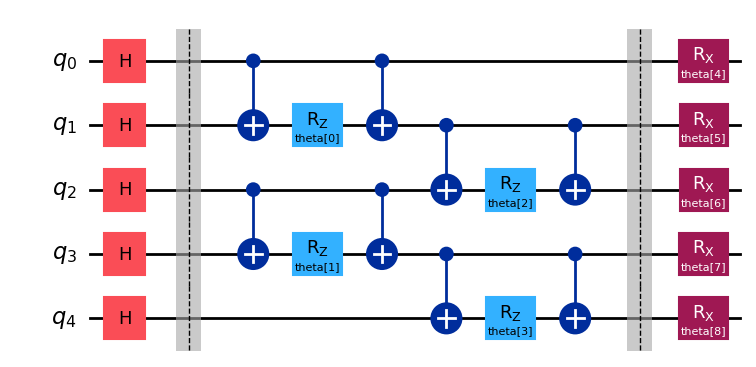

In [50]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

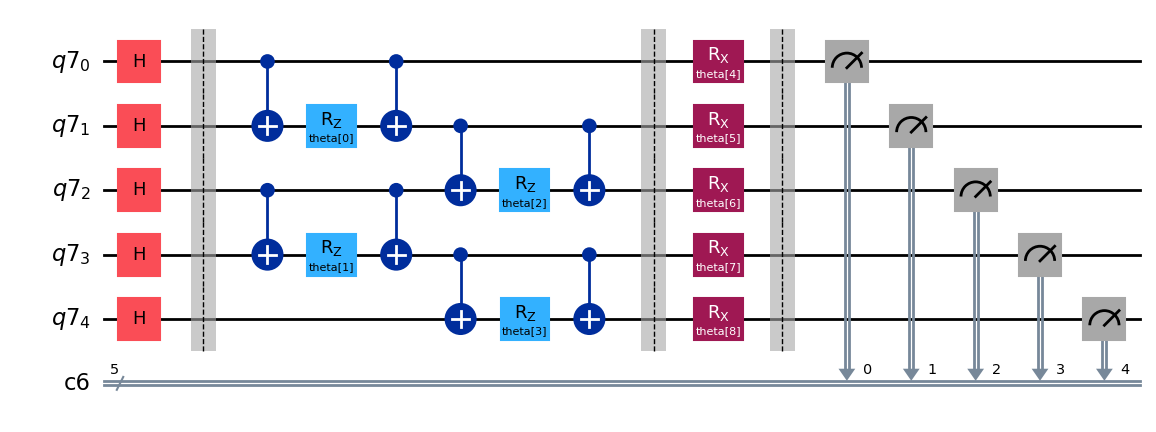

In [51]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

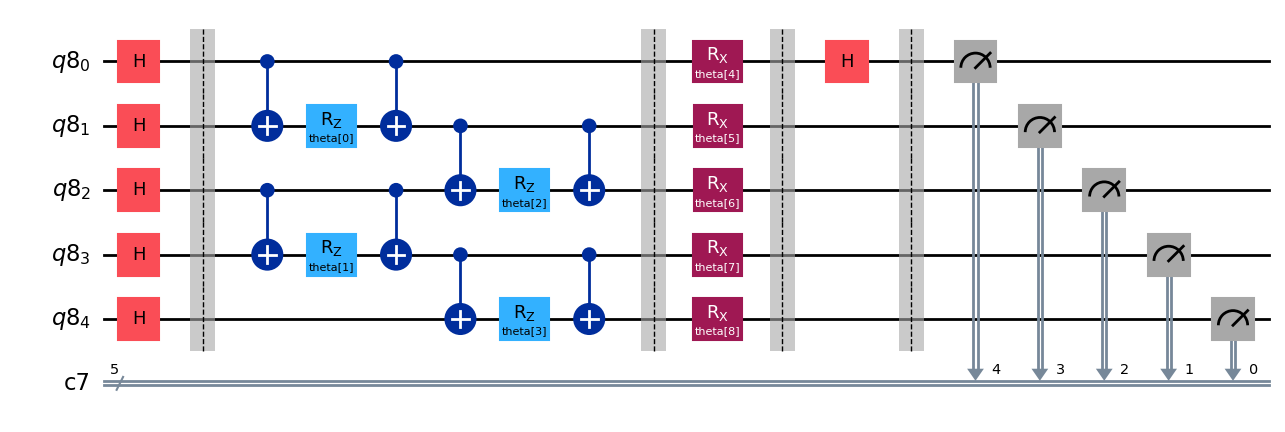

In [52]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

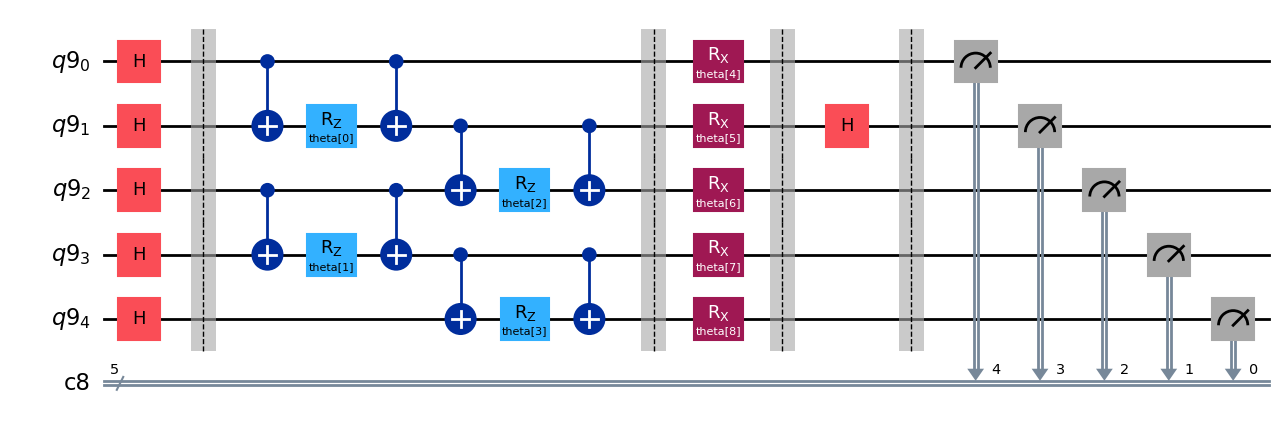

In [53]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

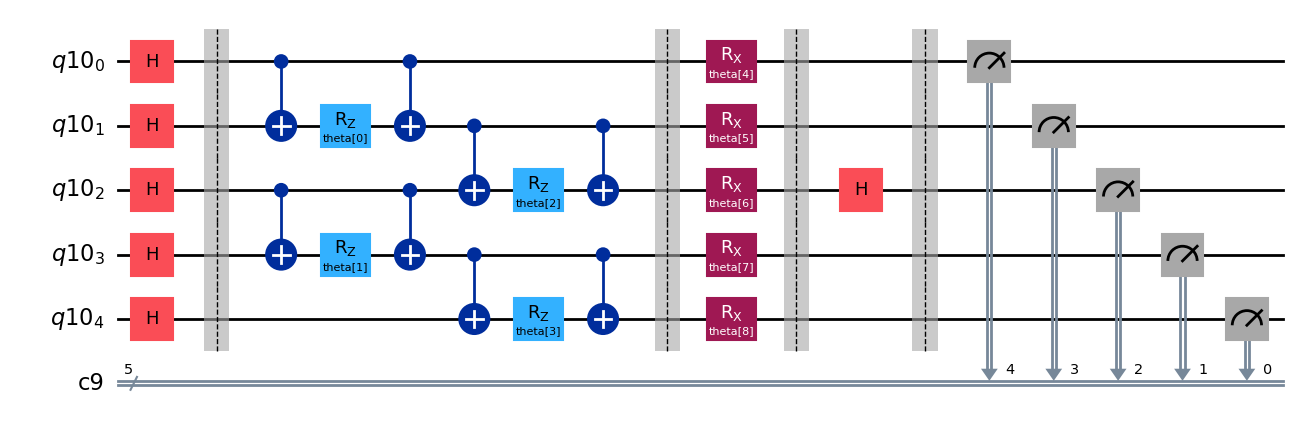

In [54]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

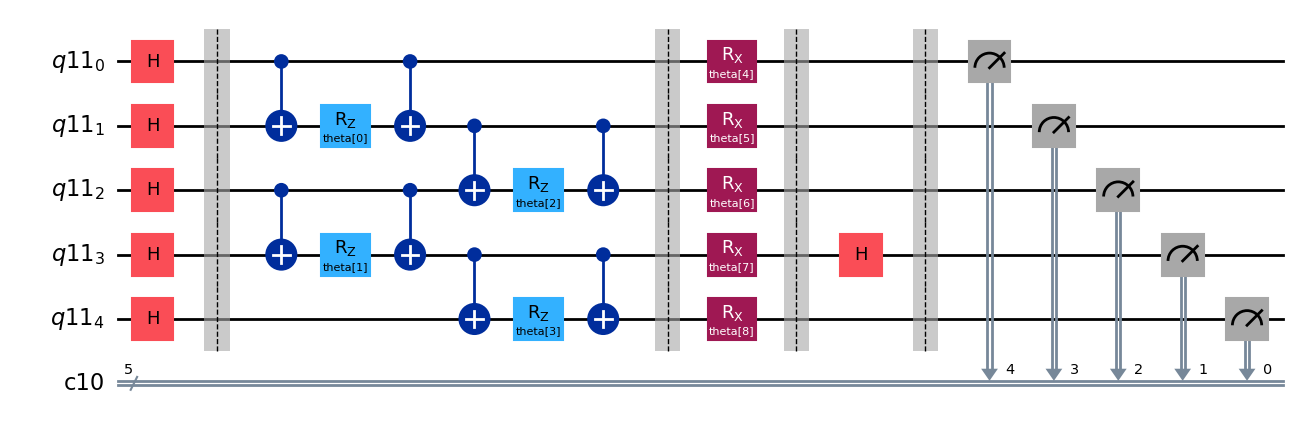

In [55]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

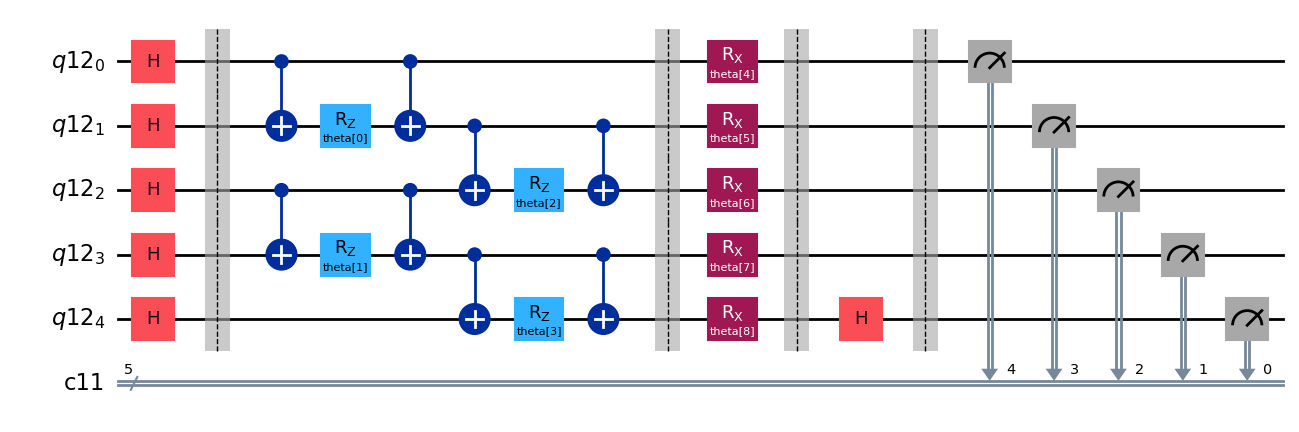

In [56]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [57]:
noise_model = NoiseModel()

# Example error probabilities
p_bit = 0.01

bit1 = pauli_error([('X', p_bit), ('I', 1 - p_bit)])
bit2 = bit1.tensor(bit1)

# QuantumError objects
noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)

## Cost Function for VQE

In [58]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8192, seed=1).result()
    return cost.values[0]

In [59]:
def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

## 1st Step : Optimizing Parameters in PQC

In [60]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(17)
x0 = 2 * np.pi * np.random.random(9)

x0

array([1.85143482, 3.33377491, 1.20336059, 0.42663053, 4.94477548,
       4.12386514, 4.00566193, 3.61661964, 0.24543954])

In [61]:
callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback_vqe,
  options=options
)

In [62]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.77734375
       x: [ 4.072e-01  5.925e+00  3.793e-01  4.251e-01  4.988e+00
            5.968e+00  5.033e+00  2.907e+00  1.807e+00]
    nfev: 122
   maxcv: 0.0

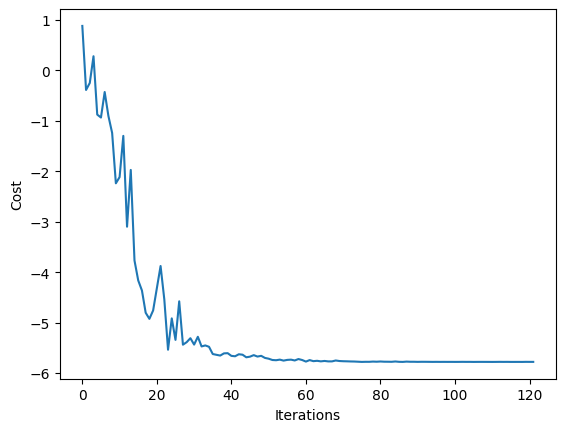

In [63]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_vqe["iters"]), callback_dict_vqe["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [64]:
params_pqc = res.x
params_pqc

array([0.40716966, 5.92539264, 0.3793108 , 0.42511258, 4.98810057,
       5.96844561, 5.03290585, 2.90659312, 1.80669553])

## Basic Cost Function for VQNHE

In [65]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [66]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [67]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [68]:
def Z0Z1(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [69]:
def X0(params_nn, ansatz_x0, params_pqc, sampler):
  job = sampler.run(ansatz_x0, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, ansatz_x1, params_pqc, sampler):
  job = sampler.run(ansatz_x1, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, ansatz_x2, params_pqc, sampler):
  job = sampler.run(ansatz_x2, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, ansatz_x3, params_pqc, sampler):
  job = sampler.run(ansatz_x3, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, ansatz_x4, params_pqc, sampler):
  job = sampler.run(ansatz_x4, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [70]:
def norm(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [71]:
def cost_func_vqnhe(params_nn, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler):
  expval = 0
  expval = expval + Z0Z1(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z1Z2(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z2Z3(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z3Z4(params_nn, ansatz_zz, params_pqc, sampler)

  expval = expval - X0(params_nn, ansatz_x0, params_pqc, sampler)
  expval = expval - X1(params_nn, ansatz_x1, params_pqc, sampler)
  expval = expval - X2(params_nn, ansatz_x2, params_pqc, sampler)
  expval = expval - X3(params_nn, ansatz_x3, params_pqc, sampler)
  expval = expval - X4(params_nn, ansatz_x4, params_pqc, sampler)

  expval = expval / norm(params_nn, ansatz_zz, params_pqc, sampler)

  return expval

In [72]:
cost_func_vqnhe(np.zeros(shape=271), params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

-5.743896484375

In [73]:
def build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Cost Function for VQNHE which suitable in calling probability a lot

In [74]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [75]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [76]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [77]:
def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [78]:
def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [79]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [80]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## 2nd Step : Opmitizing Parameters in NN for 100 times

np.random.seed(k)

k 0~100

In [81]:
np.random.seed(seed_list[12])
x_pqc_0 = 2*np.pi*np.random.random(9)

In [ ]:
local_minimum_list = []

for k in range(100):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 250
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

## Optimized Parameters

In [ ]:
# PQC optimized parameter

op_param_pqc = np.array([4.072e-01, 5.925e+00, 3.793e-01, 4.251e-01, 4.988e+00, 5.968e+00, 5.033e+00, 2.907e+00, 1.807e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([ 0.79779532, -0.31303538,  0.33832578, -0.78833468, -0.93265373,
        0.06072589,  0.08402564, -0.26809108, -0.53823268,  0.12349926,
        0.06186856,  0.74522576, -0.31721638,  0.20588489, -0.22892563,
        0.99203603,  0.55875577, -0.16914232,  0.43018575,  0.67907995,
       -0.66525475,  0.75257771,  0.83576763,  0.55277084,  0.16487362,
        0.05304298, -0.83529509,  1.05012215, -0.31079917,  0.16563369,
        0.71317516,  0.82860087, -0.52753493,  0.93821756, -0.12591755,
        0.54686046,  0.99452234, -0.32959759, -0.50464763, -0.41627262,
        0.53752114,  0.26336536, -0.16873509,  0.97287072,  0.23904333,
       -0.35804298,  0.5532935 , -1.09712812, -0.17904402,  0.34101372,
        0.497029  , -0.31095296, -0.54726443,  0.09061003, -0.54821885,
        0.47483015, -0.92601944, -0.47501584,  0.38709736,  0.1832445 ,
        0.72702394,  1.00962791,  0.69764957, -0.47311901,  0.23350536,
        0.02765795, -0.15601908,  0.48364167,  0.69420417,  0.37923525,
       -0.70075511,  0.39514729, -0.86953315, -0.6648975 ,  0.76141877,
       -0.24419607, -0.72323901,  0.37625666, -0.74769003,  0.2960676 ,
       -0.50095649, -0.92263617,  0.99191121, -0.78055677,  0.08662215,
       -0.38143972,  0.48293435,  0.70340059,  0.31044761,  0.13435625,
       -0.72941333,  0.36496248, -0.59737447,  0.05592454, -1.07774281,
       -0.46251328,  0.71171128,  0.10164277,  0.18904437, -0.29365052,
        0.59102263, -0.51782652, -0.77439957, -0.17665814, -0.45033044,
        0.4727823 , -0.62719021,  0.58107878,  0.2072505 , -0.91061658,
        0.16091331,  0.30516049,  0.93558638,  0.46724378,  0.49629563,
       -0.13169285, -0.78546958,  0.8095785 , -1.04967779,  0.05118313,
        0.13359354, -0.77416333, -0.87444752,  0.14944845, -0.02902947,
       -0.39715581, -0.92040888,  0.26778827, -0.75132863, -0.97678831,
       -0.45583695, -0.39579476, -0.63856708, -0.86920537,  0.52125107,
       -0.237929  , -0.50832027,  0.0476924 , -0.49000943,  0.70381692,
       -0.07739059,  0.33152073,  0.99326815, -0.17311885, -0.47610675,
        1.07007262,  0.10549739,  0.99630467,  0.86618039,  0.42387927,
       -0.96122838,  0.22566078, -0.50088166, -0.74112859, -0.26747773,
       -0.59981299,  0.53296283,  0.86836233, -0.9471952 , -0.48787279,
       -0.50530817, -0.72450204,  0.92855933, -0.52674958, -0.2090721 ,
       -0.89172705, -0.4844319 ,  0.71766779,  0.96349011,  0.25697977,
       -0.40627779, -0.88132805,  0.72887297, -0.68971821, -0.46090382,
        0.0964093 , -0.49544512,  0.68935617,  0.00442977, -0.03062121,
        0.78626752,  0.83053677, -0.51673857, -0.96246622,  0.32020409,
       -0.50058648, -0.9713871 , -0.80573922, -0.16232459, -0.75890355,
       -0.60832846,  0.47990976, -0.08917362, -0.7976359 , -0.47473473,
        0.90047119, -0.98740176,  0.28283218,  0.30137363,  0.36050256,
        0.14469329,  0.49010302,  0.47760182,  0.07652283, -0.92155348,
        0.25467346, -0.51163076,  0.69457195,  0.01053202, -0.86289874,
        0.82228211, -0.08464465,  0.88473398, -0.94600786, -0.79201042,
        0.49901132, -0.9126621 , -0.09539879,  0.61145358, -0.16160452,
       -0.62222967,  0.71512285, -0.74852116, -0.45461493, -0.43512277,
       -0.10919424, -0.37503322,  0.82034954,  0.5136578 ,  0.58828832,
       -0.64254254,  0.295946  ,  0.76879104,  0.91257059,  0.36551442,
       -0.11985598, -0.56744907,  0.3317435 ,  0.29439193, -0.33164051,
        0.45051529, -0.01246171,  0.60972261,  0.44366846,  0.7851254 ,
       -0.80496031,  0.8231496 ,  0.88128623,  0.32669356, -0.98121578,
       -0.96794948, -0.15286841, -0.17513443, -0.51903202,  0.60790109,
        0.36062475,  0.77038035, -0.30738169,  0.203223  , -0.49085729,
        0.45069131, -0.20833446,  0.18955707, -0.19123093,  0.32254487,
        0.34464329,  0.32922142, -0.72069563, -0.72666397,  0.68539406,
       -0.53129875])

## Plot Result of VQNHE in Noisy Simulator

VQNHE Lowest Energy Configuration for 100 times

[-5.8392458 , -5.87546176, -5.83924655, -5.8402692 , -5.94158523,
       -5.8751673 , -5.94158524, -5.94158525, -5.94158523, -5.78074357,
       -5.94158524, -5.94158525, -5.94158524, -5.77757292, -5.94145631,
       -5.93439034, -5.91385498, -5.94158136, -5.94158525, -5.77810274,
       -5.780743, -5.941585, -5.941585, -5.941585, -5.941503,
       -5.94158525, -5.78074364, -5.87516718, -5.88974625, -5.94158525,
       -5.9415852 , -5.93299599, -5.94158524, -5.90888822, -5.9316028 ,
       -5.94158525, -5.9380279 , -5.80099864, -5.7535819 , -5.77514423,
       -5.90469022, -5.94158524, -5.94158523, -5.94158525, -5.83924657,
       -5.94158524, -5.93917358, -5.94154199, -5.84026916, -5.77825212,
       -5.93705511, -5.78074338, -5.94156212, -5.94158525, -5.93272868,
       -5.94158525, -5.94158525, -5.86214847, -5.941585  , -5.77816882,
       -5.81901766, -5.94148885, -5.82826786, -5.83924583, -5.77273822,
       -5.94158524, -5.84258761, -5.94158525, -5.9415604 , -5.93799288,
       -5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018  ,
       -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508,
       -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525,
       -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252,
       -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523,
       -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634]

VQE Lowest Energy Configuration for 100 times

[-5.606,   -5.71875, -5.60175, -5.698,   -5.78125, -5.767,   -5.5845,  -5.645,
 -5.69425, -5.51475, -5.56775, -5.75575, -5.769,   -5.57125, -5.64275, -5.74275,
 -5.5175,  -5.7255,  -5.666,   -5.73625, -5.723,   -5.7545,  -5.6705,  -5.60075,
 -5.52975, -5.6935,  -5.61425, -5.6985,  -5.69325, -5.6845,  -5.73225, -5.72175,
 -5.6815,  -5.31325, -5.7015,  -5.70625, -5.68925, -5.738,   -5.71325, -5.672,
 -5.66375, -5.618,   -5.6725,  -5.6015,  -5.615,   -5.7535,  -5.52925, -5.767,
 -5.736,   -5.7325,  -5.647,   -5.6445,  -5.72275, -5.55,    -5.67225, -5.68075,
 -5.7195,  -5.6425,  -5.7215,  -5.60475, -5.72025, -5.709,   -5.58275, -5.7115,
 -5.7125,  -5.6935,  -5.6955,  -5.53825, -5.53225, -5.52125, -5.64025, -5.644,
 -5.7355,  -5.6575,  -5.6785,  -5.56625, -5.762,   -5.6985,  -5.697,   -5.63975,
 -5.61525, -5.68075, -5.76425, -5.7605,  -5.699,   -5.57325, -5.707,   -5.57125,
 -5.74275, -5.68675, -5.4285,  -5.7675,  -5.76325, -5.6595,  -5.71025, -5.66375,
 -5.6435,  -5.726,   -5.67075, -5.62425]

In [ ]:
vqnhe_minimum_list = np.array([-5.8392458 , -5.87546176, -5.83924655, -5.8402692 , -5.94158523,
       -5.8751673 , -5.94158524, -5.94158525, -5.94158523, -5.78074357,
       -5.94158524, -5.94158525, -5.94158524, -5.77757292, -5.94145631,
       -5.93439034, -5.91385498, -5.94158136, -5.94158525, -5.77810274,
       -5.780743, -5.941585, -5.941585, -5.941585, -5.941503,
       -5.94158525, -5.78074364, -5.87516718, -5.88974625, -5.94158525,
       -5.9415852 , -5.93299599, -5.94158524, -5.90888822, -5.9316028 ,
       -5.94158525, -5.9380279 , -5.80099864, -5.7535819 , -5.77514423,
       -5.90469022, -5.94158524, -5.94158523, -5.94158525, -5.83924657,
       -5.94158524, -5.93917358, -5.94154199, -5.84026916, -5.77825212,
       -5.93705511, -5.78074338, -5.94156212, -5.94158525, -5.93272868,
       -5.94158525, -5.94158525, -5.86214847, -5.941585  , -5.77816882,
       -5.81901766, -5.94148885, -5.82826786, -5.83924583, -5.77273822,
       -5.94158524, -5.84258761, -5.94158525, -5.9415604 , -5.93799288,
       -5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018  ,
       -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508,
       -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525,
       -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252,
       -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523,
       -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634])

In [ ]:
vqe_minimum_list = np.array([-5.606,   -5.71875, -5.60175, -5.698,   -5.78125, -5.767,   -5.5845,  -5.645,
 -5.69425, -5.51475, -5.56775, -5.75575, -5.769,   -5.57125, -5.64275, -5.74275,
 -5.5175,  -5.7255,  -5.666,   -5.73625, -5.723,   -5.7545,  -5.6705,  -5.60075,
 -5.52975, -5.6935,  -5.61425, -5.6985,  -5.69325, -5.6845,  -5.73225, -5.72175,
 -5.6815,  -5.31325, -5.7015,  -5.70625, -5.68925, -5.738,   -5.71325, -5.672,
 -5.66375, -5.618,   -5.6725,  -5.6015,  -5.615,   -5.7535,  -5.52925, -5.767,
 -5.736,   -5.7325,  -5.647,   -5.6445,  -5.72275, -5.55,    -5.67225, -5.68075,
 -5.7195,  -5.6425,  -5.7215,  -5.60475, -5.72025, -5.709,   -5.58275, -5.7115,
 -5.7125,  -5.6935,  -5.6955,  -5.53825, -5.53225, -5.52125, -5.64025, -5.644,
 -5.7355,  -5.6575,  -5.6785,  -5.56625, -5.762,   -5.6985,  -5.697,   -5.63975,
 -5.61525, -5.68075, -5.76425, -5.7605,  -5.699,   -5.57325, -5.707,   -5.57125,
 -5.74275, -5.68675, -5.4285,  -5.7675,  -5.76325, -5.6595,  -5.71025, -5.66375,
 -5.6435,  -5.726,   -5.67075, -5.62425])

In [ ]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.8948130873
variance : 0.004279121675433017
maximum : -5.7362738
minimum : -5.94158525

[-5.8392458  -5.87546176 -5.83924655 -5.8402692  -5.94158523 -5.8751673
 -5.94158524 -5.94158525 -5.94158523 -5.78074357 -5.94158524 -5.94158525
 -5.94158524 -5.77757292 -5.94145631 -5.93439034 -5.91385498 -5.94158136
 -5.94158525 -5.77810274 -5.780743   -5.941585   -5.941585   -5.941585
 -5.941503   -5.94158525 -5.78074364 -5.87516718 -5.88974625 -5.94158525
 -5.9415852  -5.93299599 -5.94158524 -5.90888822 -5.9316028  -5.94158525
 -5.9380279  -5.80099864 -5.7535819  -5.77514423 -5.90469022 -5.94158524
 -5.94158523 -5.94158525 -5.83924657 -5.94158524 -5.93917358 -5.94154199
 -5.84026916 -5.77825212 -5.93705511 -5.78074338 -5.94156212 -5.94158525
 -5.93272868 -5.94158525 -5.94158525 -5.86214847 -5.941585   -5.77816882
 -5.81901766 -5.94148885 -5.82826786 -5.83924583 -5.77273822 -5.94158524
 -5.84258761 -5.94158525 -5.9415604  -5.93799288 -5.9415426  -5.94158525
 -5.94158525 -5.94158525 -5.93

In [ ]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.6661791994
variance : 0.006554347254818564
maximum : -5.34375
minimum : -5.77734375

[-5.60742188 -5.76147461 -5.60180664 -5.70556641 -5.69165039 -5.76611328
 -5.65112305 -5.64379883 -5.53466797 -5.55786133 -5.57275391 -5.75830078
 -5.77734375 -5.59106445 -5.60424805 -5.71679688 -5.4831543  -5.73168945
 -5.67578125 -5.73046875 -5.74951172 -5.77416992 -5.68432617 -5.6496582
 -5.51489258 -5.70556641 -5.6237793  -5.66503906 -5.71142578 -5.68334961
 -5.71533203 -5.74560547 -5.71630859 -5.34375    -5.70336914 -5.70239258
 -5.70874023 -5.73583984 -5.57202148 -5.56396484 -5.6862793  -5.63623047
 -5.56738281 -5.60766602 -5.6418457  -5.69580078 -5.55810547 -5.74438477
 -5.72167969 -5.72680664 -5.67480469 -5.61572266 -5.42407227 -5.51489258
 -5.67822266 -5.74609375 -5.69677734 -5.66601562 -5.73046875 -5.57861328
 -5.55273438 -5.76977539 -5.69750977 -5.70141602 -5.6484375  -5.73706055
 -5.7121582  -5.77319336 -5.60473633 -5.68017578 -5.64233398 -5.59057617
 -5.74365234 -5.67236328 -5.60

# VQNHE in Noisy Simulator (Depolarization Channel, 0.01)

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [85]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [86]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

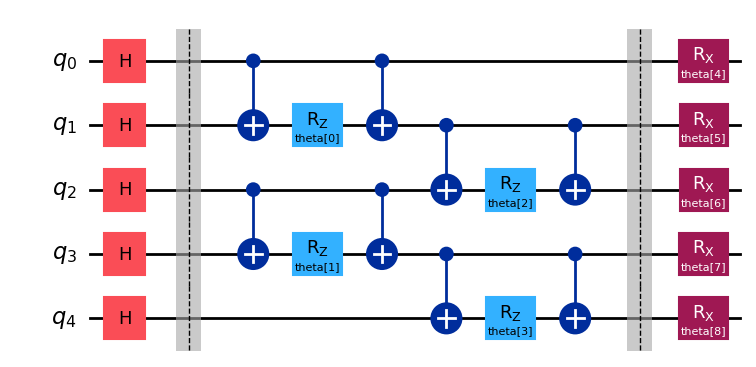

In [87]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

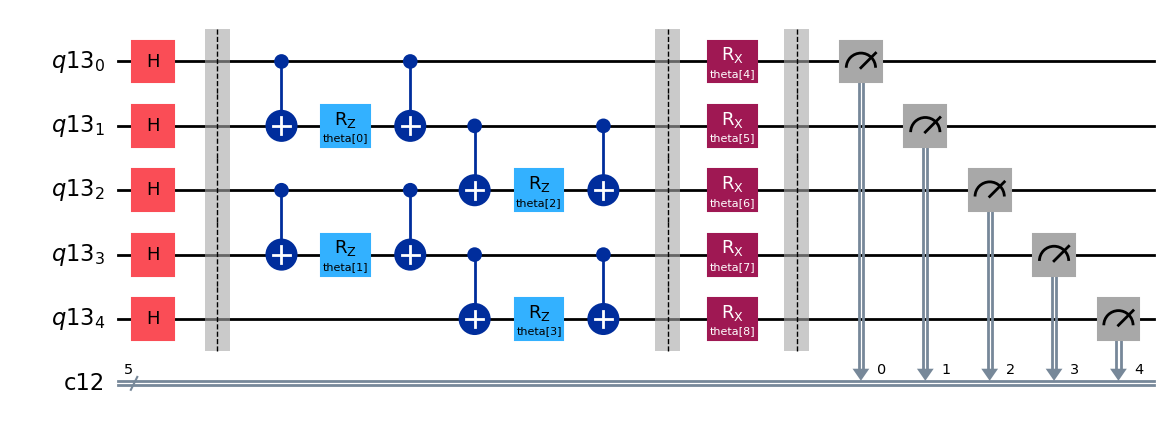

In [88]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

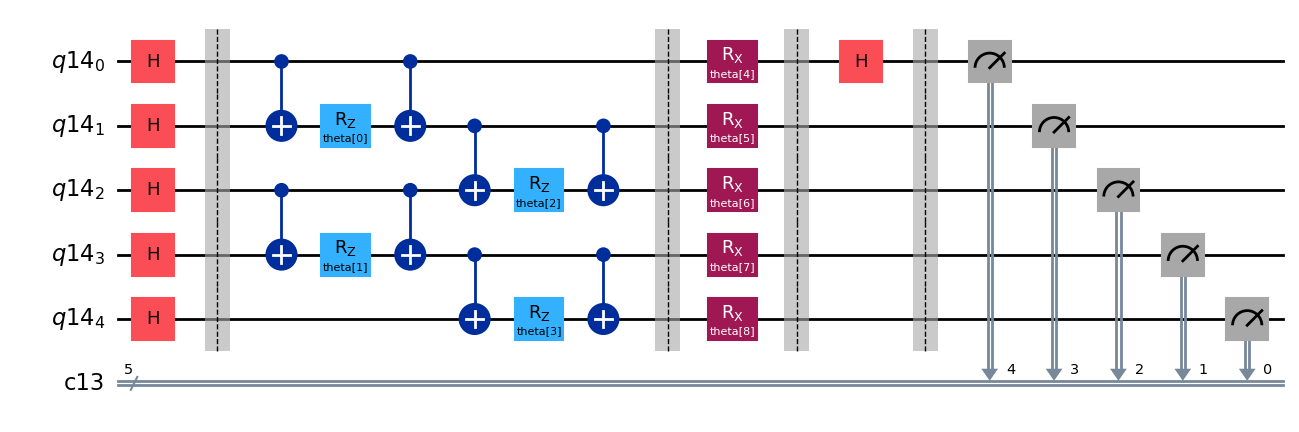

In [89]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

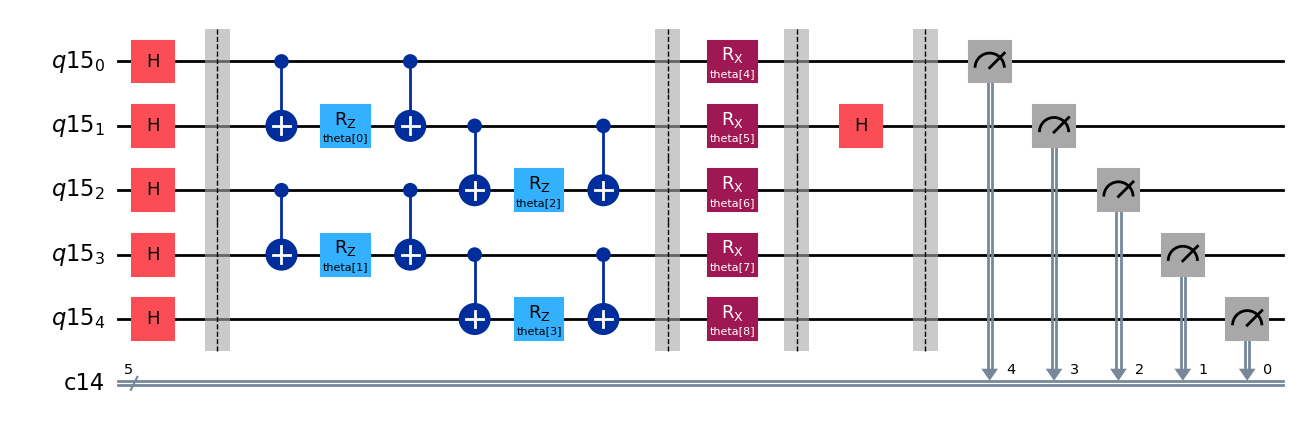

In [90]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

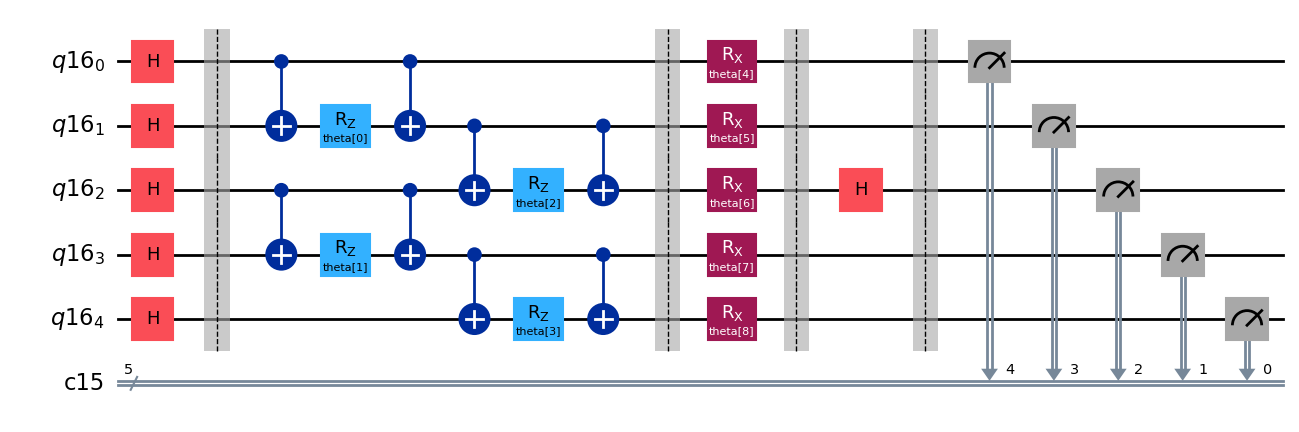

In [91]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

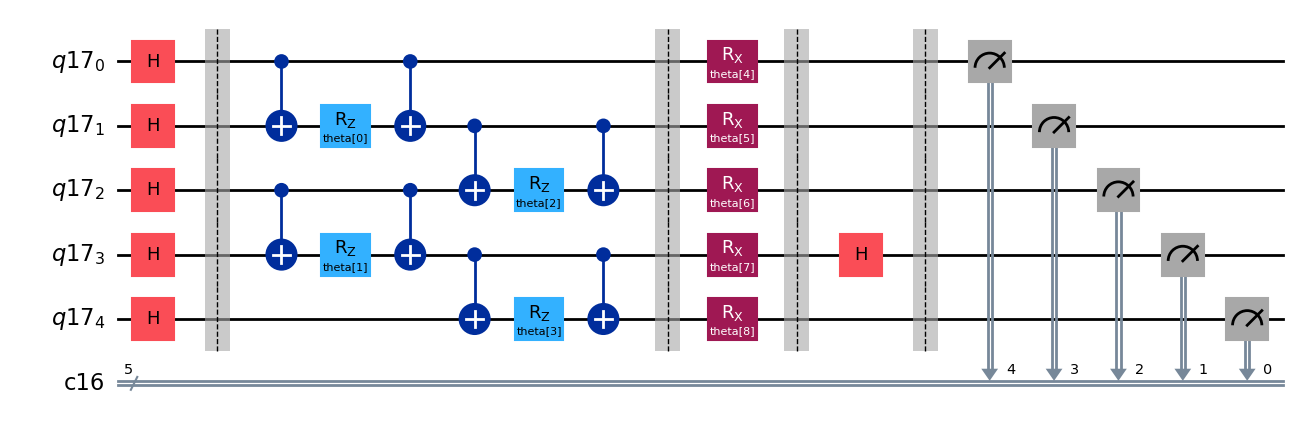

In [92]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

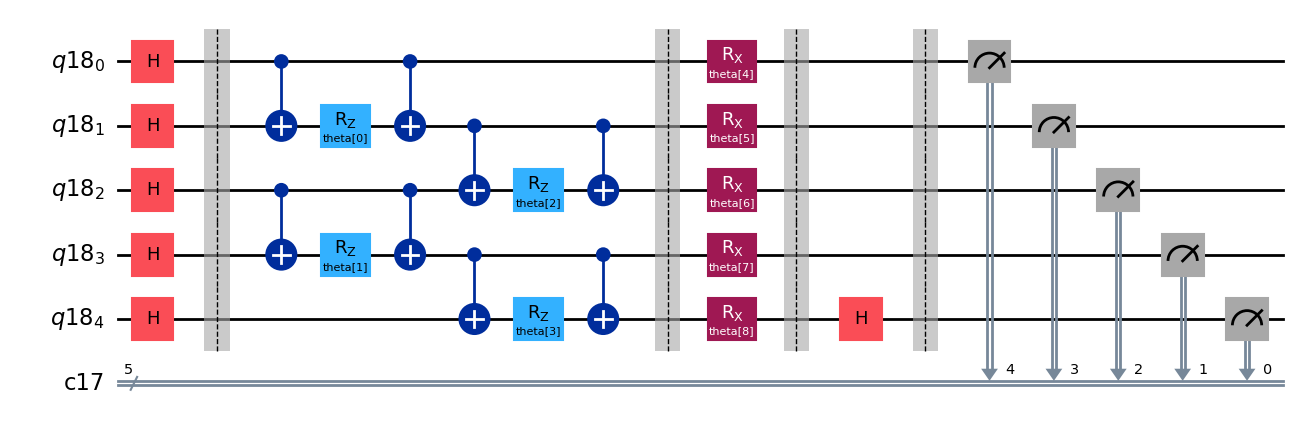

In [93]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [94]:
noise_model = NoiseModel()

# Example error probabilities
u_depolarizing_prob = 0.01
cx_depolarizing_prob = 0.01

# QuantumError objects
noise_model.add_all_qubit_quantum_error(depolarizing_error(u_depolarizing_prob, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)

## Cost Function for VQE

In [95]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8192, seed=1).result()
    return cost.values[0]

In [96]:
def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

## 1st Step : Optimizing Parameters in PQC

In [97]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(7)
x0 = 2 * np.pi * np.random.random(9)

x0

array([0.47945912, 4.9003743 , 2.75460644, 4.54566578, 6.14488933,
       3.38346934, 3.14863273, 0.45271062, 1.68665186])

In [98]:
callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback_vqe,
  options=options
)

In [99]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.7119140625
       x: [ 4.888e-01  6.652e+00  5.860e+00  5.798e+00  8.011e+00
            3.007e+00  4.701e+00 -1.087e-02  1.616e+00]
    nfev: 140
   maxcv: 0.0

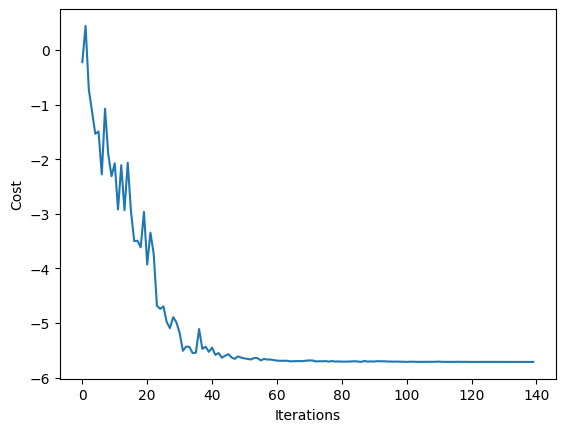

In [100]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_vqe["iters"]), callback_dict_vqe["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [101]:
params_pqc = res.x
params_pqc

array([ 0.48879873,  6.65211382,  5.86048949,  5.79826073,  8.01051265,
        3.00663493,  4.70126017, -0.0108672 ,  1.61623809])

## Basic Cost Function for VQNHE

In [102]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [103]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]

In [104]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [105]:
def Z0Z1(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [106]:
def X0(params_nn, ansatz_x0, params_pqc, sampler):
  job = sampler.run(ansatz_x0, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, ansatz_x1, params_pqc, sampler):
  job = sampler.run(ansatz_x1, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, ansatz_x2, params_pqc, sampler):
  job = sampler.run(ansatz_x2, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, ansatz_x3, params_pqc, sampler):
  job = sampler.run(ansatz_x3, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, ansatz_x4, params_pqc, sampler):
  job = sampler.run(ansatz_x4, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [107]:
def norm(params_nn, ansatz_zz, params_pqc, sampler):
  job = sampler.run(ansatz_zz, params_pqc, shots=8192, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [108]:
def cost_func_vqnhe(params_nn, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler):
  expval = 0
  expval = expval + Z0Z1(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z1Z2(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z2Z3(params_nn, ansatz_zz, params_pqc, sampler)
  expval = expval + Z3Z4(params_nn, ansatz_zz, params_pqc, sampler)

  expval = expval - X0(params_nn, ansatz_x0, params_pqc, sampler)
  expval = expval - X1(params_nn, ansatz_x1, params_pqc, sampler)
  expval = expval - X2(params_nn, ansatz_x2, params_pqc, sampler)
  expval = expval - X3(params_nn, ansatz_x3, params_pqc, sampler)
  expval = expval - X4(params_nn, ansatz_x4, params_pqc, sampler)

  expval = expval / norm(params_nn, ansatz_zz, params_pqc, sampler)

  return expval

In [109]:
cost_func_vqnhe(np.zeros(shape=271), params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

-5.643310546875

In [110]:
def build_callback_vqnhe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Cost Function for VQNHE which suitable in calling probability a lot

In [124]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [125]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=8000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [126]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [127]:
def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [128]:
def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [129]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [130]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## 2nd Step : Opmitizing Parameters in NN for 100 times

np.random.seed(k)

k 0~100

In [131]:
np.random.seed(seed_list[4])
x_pqc_0 = 2*np.pi*np.random.random(9)

array([0.47945912, 4.9003743 , 2.75460644, 4.54566578, 6.14488933,
       3.38346934, 3.14863273, 0.45271062, 1.68665186])

In [119]:
local_minimum_list = []

for k in range(100):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 250
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

Optimization terminated successfully.
         Current function value: -5.905367
         Iterations: 150
         Function evaluations: 46512
         Gradient evaluations: 171


In [120]:
local_minimum_list

array([-5.90536707])

## Optimized Parameters

In [ ]:
# PQC optimized parameter

op_param_pqc = np.array([4.072e-01, 5.925e+00, 3.793e-01, 4.251e-01, 4.988e+00, 5.968e+00, 5.033e+00, 2.907e+00, 1.807e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([ 8.27698058e-01, -1.30754941e-01,  1.23612391e+00,  4.52444164e-01,
       -1.38091053e-01, -4.63555358e-01,  9.82114653e-01, -9.84505425e-01,
       -4.30265916e-01,  1.33949062e-01,  5.36748502e-01, -4.78195394e-01,
        8.90867579e-01,  1.06966050e+00, -4.37351266e-01, -3.26506991e-02,
       -3.07596256e-01,  3.60091311e-01, -1.29383095e+00,  1.27422355e+00,
       -4.74815793e-02,  9.35477112e-01,  8.18103568e-01,  5.87389536e-01,
       -3.70526889e-01, -8.50102826e-01,  2.65454213e-01, -5.92398371e-01,
        4.45697404e-01, -1.38603438e-01, -4.08815213e-01,  2.84136113e-01,
       -3.83510268e-01, -1.15048152e+00, -1.10467137e+00,  3.08936464e-01,
       -2.33077128e-01,  2.86549105e-02, -6.47638427e-02,  1.32080852e-02,
       -5.00201424e-01,  6.96026094e-01,  2.85716309e-01, -4.64360711e-01,
        3.29200047e-01,  7.05988761e-01,  1.01894306e-01, -3.45295467e-01,
        2.97165380e-01,  1.90280081e-01,  6.90011427e-01, -3.40849003e-01,
        2.24789304e-01, -6.44996250e-01,  7.92371368e-04, -6.03046605e-01,
        8.09039627e-01, -2.33990940e-01,  6.15183904e-01, -3.89129665e-01,
        7.41610740e-01, -1.97186618e-01, -1.77168259e-01,  1.33234892e-01,
        5.58043035e-01,  7.42496075e-01,  1.53569617e-01, -7.13255993e-01,
        1.67452427e-01, -2.66898456e-01,  5.96494546e-01,  6.08224867e-01,
        4.07479257e-01,  3.03553432e-01, -7.82986154e-01,  2.20842107e-01,
       -7.95798079e-01,  1.91836917e-01, -5.10180867e-01,  4.96912000e-01,
       -1.05326737e+00, -7.59287892e-01,  4.02416317e-01, -1.87029754e-02,
        2.23964350e-01,  6.57394289e-01,  1.74548175e-02,  5.39968088e-01,
        2.00470609e-02,  7.36328999e-01, -3.50888631e-01, -6.93716833e-01,
       -5.43857919e-01,  3.60960268e-01, -4.86235322e-01, -6.21948481e-01,
       -7.45700626e-02, -3.58937200e-01,  1.57047596e-01, -3.45635838e-01,
       -4.05459634e-01, -1.56075721e-01,  5.82159568e-02,  7.75856204e-01,
        9.76806844e-01,  2.61319901e-01, -8.28552493e-01,  4.87596390e-01,
        3.31324265e-01,  7.04684741e-01, -1.84041230e-01, -9.29878706e-01,
        2.61890916e-01, -7.32339162e-01,  5.95776099e-01,  5.76184520e-01,
       -1.88287301e-01,  9.01592728e-01, -6.28840760e-01,  8.38269407e-01,
       -2.36558127e-01,  5.03411975e-01,  5.37164437e-01,  8.68546866e-01,
        8.40520487e-01, -8.88729011e-01, -9.78627768e-01,  1.21346920e-01,
       -9.21437541e-01,  4.32470704e-01,  1.32570761e-01,  3.50536646e-01,
       -6.26876195e-02, -3.30312891e-01,  1.11713225e+00,  4.49888997e-01,
       -9.32858075e-01, -8.39571724e-01,  2.61832320e-01, -6.52069690e-01,
       -1.07448295e-01,  5.48284529e-01, -3.90630123e-01,  8.95933855e-01,
        4.06165547e-01,  1.26782717e-01, -6.45128321e-01, -1.31598588e-01,
        5.06856701e-01,  1.02330119e+00, -8.98062140e-01, -7.30976032e-01,
        4.26965685e-01,  7.51243579e-01, -8.49086281e-01,  6.36824909e-01,
        5.70759335e-01,  3.52956786e-01, -3.22818250e-01, -1.08409416e-01,
       -3.44390146e-01,  6.93464254e-01, -4.33306451e-01, -3.54224388e-01,
        7.98173931e-01,  8.23062698e-01,  9.12164094e-01,  6.18662887e-01,
       -8.57465849e-01, -8.01497364e-01, -6.57834244e-02,  7.25495729e-01,
        7.30720119e-01,  2.32325942e-01,  7.44502007e-01, -6.84354920e-01,
       -6.25825604e-01, -3.06487315e-01, -5.12900167e-01, -2.96887676e-01,
       -1.01294728e+00, -2.07555926e-01, -9.37732375e-01,  1.63823690e-01,
        4.90269956e-01, -6.59770043e-02,  1.73721071e-01,  2.14394426e-01,
        6.09433253e-01,  6.05405761e-01,  6.69091808e-01, -3.97000447e-01,
        7.77670678e-01, -6.62247932e-01, -2.05629067e-01,  4.48784695e-01,
       -3.41421862e-01,  7.24721717e-01,  6.35273683e-01, -7.90807476e-01,
       -5.73914046e-01, -8.95130243e-01,  6.68821360e-01, -3.21819845e-01,
       -2.38636875e-01, -4.73704564e-01, -7.53434421e-01, -9.27761624e-02,
       -5.30565894e-01,  1.32719803e-01, -3.90470865e-01, -8.39600460e-03,
        8.48251906e-01, -1.96617598e-01,  1.02954146e+00, -9.03965528e-01,
        8.24872373e-02,  1.81881319e-01,  9.49322058e-01,  6.64895822e-01,
       -1.45999349e-01,  5.41688753e-01,  9.40933089e-01,  4.15299623e-01,
        7.92910347e-01,  8.72891436e-01, -6.21420645e-02,  3.33789816e-01,
       -6.47909440e-01, -2.18100582e-02,  6.98630894e-01,  1.63750030e-01,
       -5.08476247e-01, -7.80091398e-01, -5.25284499e-01, -7.47650483e-01,
       -5.23448482e-01, -2.31169294e-01, -9.11481233e-01,  6.37873658e-01,
       -9.44460975e-02,  1.14030134e-01,  2.58736678e-01, -7.32205760e-01,
       -8.93107768e-01, -6.68764822e-01,  9.61085758e-01, -7.45277484e-01,
       -1.62126517e-01,  8.03789639e-01,  2.50654504e-01, -4.06286691e-01,
        7.24524371e-01, -1.96305369e-01, -7.47885710e-01, -2.04479968e-01,
        2.20910205e-01, -7.00485290e-01,  8.11475299e-01,  4.89854838e-01,
       -6.56749242e-01, -1.64802672e-01, -3.62598738e-01, -5.53496689e-01,
        3.12482999e-01, -9.37002414e-02,  3.30270679e-01, -3.94707447e-01,
        1.48609148e-01,  3.44982031e-01, -7.50480783e-01])

## Plot Result of VQNHE in Noisy Simulator

VQNHE Lowest Energy Configuration for 100 times

[-5.9053623802295565, -5.905284848147373, -5.905211478978276, -5.895858287602114, -5.9053670725564595, -5.8043448004934834, -5.804216265436067, -5.9053671677560144, -5.752514185468417, -5.897287131337429, -5.90536716339884, -5.905367166698549, -5.905367169860917, -5.905366212511115, -5.904065368082751, -5.903511757937208, -5.902001867053614, -5.90536713629146, -5.905367170062944, -5.696496721765803, -5.752514690831475, -5.897556454107229, -5.905367157774968, -5.905367169035556, -5.835788569713097, -5.905367168407769, -5.892477704240274, -5.905366768357541, -5.713177433384576, -5.855618175239319, -5.905367132178551, -5.902231709331003, -5.897446083779941, -5.752514879860089, -5.89728312783902, -5.905367170026302, -5.751604752708811, -5.866904315858801, -5.897398650176224, -5.905367160053486, -5.905367141533028, -5.905367136958099, -5.897443379760443, -5.718947929766712, -5.801289565304456, -5.905359403128855, -5.896698642251029, -5.905367030164439, -5.905278886377779, -5.6827271876812695, -5.734734249353867, -5.9053623802295565, -5.905284848147373, -5.905211478978276, -5.895858287602114, -5.9053670725564595, -5.8043448004934834, -5.804216265436067, -5.9053671677560144, -5.752514185468417, -5.897287131337429, -5.90536716339884, -5.905367166698549, -5.905367169860917, -5.905366212511115, -5.904065368082751, -5.903511757937208, -5.902001867053614, -5.90536713629146, -5.905367170062944, -5.696496721765803, -5.752514690831475, -5.897556454107229, -5.905367157774968, -5.905367169035556, -5.835788569713097, -5.905367168407769, -5.892477704240274, -5.905366768357541, -5.713177433384576, -5.855618175239319, -5.905367132178551, -5.902231709331003, -5.897446083779941, -5.752514879860089, -5.89728312783902, -5.905367170026302, -5.751604752708811, -5.866904315858801, -5.897398650176224, -5.905367160053486, -5.905367141533028, -5.905367136958099, -5.897285675121541, -5.90528534171424, -5.89742821, -5.80434494, -5.70794607, -5.72243123, -5.90536717]

VQE Lowest Energy Configuration for 100 times

[-5.464,   -5.5505,  -5.50125, -5.64825, -5.70225, -5.70025, -5.43825, -5.57275,
 -5.4745,  -5.6055,  -5.66075, -5.692,   -5.68175, -5.47775, -5.317,   -5.67375,
 -5.529,   -5.657,   -5.55025, -5.46625, -5.69025, -5.67975, -5.631,   -5.4515,
 -5.412,   -5.6265,  -5.53575, -5.43025, -5.5855,  -5.4955,  -5.6855,  -5.6505,
 -5.672,   -5.35175, -5.65225, -5.65475, -5.4135,  -5.56525, -5.438,   -5.6115,
 -5.5225,  -5.52325, -5.55525, -5.501,   -5.3635,  -5.70075, -5.649,   -5.7025,
 -5.4855,  -5.625,   -5.6135,  -5.633,   -5.43725, -5.46675, -5.6255,  -5.704,
 -5.432,   -5.55775, -5.686,   -5.511,   -5.4655,  -5.68625, -5.5895,  -5.5275,
 -5.5875,  -5.432,   -5.30525, -5.475,   -5.6845,  -5.6685,  -5.56775, -5.686,
 -5.502,   -5.615,   -5.6445,  -5.5425,  -5.67275, -5.57275, -5.614,   -5.57625,
 -5.68275, -5.572,   -5.68975, -5.66025, -5.5175,  -5.597,   -5.653,   -5.49375,
 -5.71,    -5.3725,  -5.61425, -5.67175, -5.671,   -5.55375, -5.63675, -5.5605,
 -5.66775, -5.65575, -5.62475, -5.5515 ]

In [140]:
vqnhe_minimum_list = np.array([[-5.9053623802295565, -5.905284848147373, -5.905211478978276, -5.895858287602114, -5.9053670725564595, -5.8043448004934834, -5.804216265436067, -5.9053671677560144, -5.752514185468417, -5.897287131337429, -5.90536716339884, -5.905367166698549, -5.905367169860917, -5.905366212511115, -5.904065368082751, -5.903511757937208, -5.902001867053614, -5.90536713629146, -5.905367170062944, -5.696496721765803, -5.752514690831475, -5.897556454107229, -5.905367157774968, -5.905367169035556, -5.835788569713097, -5.905367168407769, -5.892477704240274, -5.905366768357541, -5.713177433384576, -5.855618175239319, -5.905367132178551, -5.902231709331003, -5.897446083779941, -5.752514879860089, -5.89728312783902, -5.905367170026302, -5.751604752708811, -5.866904315858801, -5.897398650176224, -5.905367160053486, -5.905367141533028, -5.905367136958099, -5.897443379760443, -5.718947929766712, -5.801289565304456, -5.905359403128855, -5.896698642251029, -5.905367030164439, -5.905278886377779, -5.6827271876812695, -5.734734249353867, -5.9053623802295565, -5.905284848147373, -5.905211478978276, -5.895858287602114, -5.9053670725564595, -5.8043448004934834, -5.804216265436067, -5.9053671677560144, -5.752514185468417, -5.897287131337429, -5.90536716339884, -5.905367166698549, -5.905367169860917, -5.905366212511115, -5.904065368082751, -5.903511757937208, -5.902001867053614, -5.90536713629146, -5.905367170062944, -5.696496721765803, -5.752514690831475, -5.897556454107229, -5.905367157774968, -5.905367169035556, -5.835788569713097, -5.905367168407769, -5.892477704240274, -5.905366768357541, -5.713177433384576, -5.855618175239319, -5.905367132178551, -5.902231709331003, -5.897446083779941, -5.752514879860089, -5.89728312783902, -5.905367170026302, -5.751604752708811, -5.866904315858801, -5.897398650176224, -5.905367160053486, -5.905367141533028, -5.905367136958099, -5.897285675121541, -5.90528534171424, -5.89742821, -5.80434494, -5.70794607, -5.72243123, -5.90536717]])

In [141]:
vqe_minimum_list = np.array([-5.464,   -5.5505,  -5.50125, -5.64825, -5.70225, -5.70025, -5.43825, -5.57275,
 -5.4745,  -5.6055,  -5.66075, -5.692,   -5.68175, -5.47775, -5.317,   -5.67375,
 -5.529,   -5.657,   -5.55025, -5.46625, -5.69025, -5.67975, -5.631,   -5.4515,
 -5.412,   -5.6265,  -5.53575, -5.43025, -5.5855,  -5.4955,  -5.6855,  -5.6505,
 -5.672,   -5.35175, -5.65225, -5.65475, -5.4135,  -5.56525, -5.438,   -5.6115,
 -5.5225,  -5.52325, -5.55525, -5.501,   -5.3635,  -5.70075, -5.649,   -5.7025,
 -5.4855,  -5.625,   -5.6135,  -5.633,   -5.43725, -5.46675, -5.6255,  -5.704,
 -5.432,   -5.55775, -5.686,   -5.511,   -5.4655,  -5.68625, -5.5895,  -5.5275,
 -5.5875,  -5.432,   -5.30525, -5.475,   -5.6845,  -5.6685,  -5.56775, -5.686,
 -5.502,   -5.615,   -5.6445,  -5.5425,  -5.67275, -5.57275, -5.614,   -5.57625,
 -5.68275, -5.572,   -5.68975, -5.66025, -5.5175,  -5.597,   -5.653,   -5.49375,
 -5.71,    -5.3725,  -5.61425, -5.67175, -5.671,   -5.55375, -5.63675, -5.5605,
 -5.66775, -5.65575, -5.62475, -5.5515 ])

In [142]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.864477587167517
variance : 0.004482484727256816
maximum : -5.6827271876812695
minimum : -5.905367170062944

[[-5.90536238 -5.90528485 -5.90521148 -5.89585829 -5.90536707 -5.8043448
  -5.80421627 -5.90536717 -5.75251419 -5.89728713 -5.90536716 -5.90536717
  -5.90536717 -5.90536621 -5.90406537 -5.90351176 -5.90200187 -5.90536714
  -5.90536717 -5.69649672 -5.75251469 -5.89755645 -5.90536716 -5.90536717
  -5.83578857 -5.90536717 -5.8924777  -5.90536677 -5.71317743 -5.85561818
  -5.90536713 -5.90223171 -5.89744608 -5.75251488 -5.89728313 -5.90536717
  -5.75160475 -5.86690432 -5.89739865 -5.90536716 -5.90536714 -5.90536714
  -5.89744338 -5.71894793 -5.80128957 -5.9053594  -5.89669864 -5.90536703
  -5.90527889 -5.68272719 -5.73473425 -5.90536238 -5.90528485 -5.90521148
  -5.89585829 -5.90536707 -5.8043448  -5.80421627 -5.90536717 -5.75251419
  -5.89728713 -5.90536716 -5.90536717 -5.90536717 -5.90536621 -5.90406537
  -5.90351176 -5.90200187 -5.90536714 -5.90536717 -5.69649672 -5.7525

In [143]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.586889648299999
variance : 0.008558568350821843
maximum : -5.30737305
minimum : -5.71191406

[-5.48925781 -5.63330078 -5.50708008 -5.65844727 -5.71191406 -5.67211914
 -5.5168457  -5.52661133 -5.49560547 -5.53027344 -5.5390625  -5.68554688
 -5.67993164 -5.60058594 -5.52612305 -5.7043457  -5.48461914 -5.66235352
 -5.54125977 -5.49267578 -5.70239258 -5.70092773 -5.65844727 -5.45385742
 -5.42236328 -5.63378906 -5.52856445 -5.46069336 -5.57202148 -5.60620117
 -5.64477539 -5.64379883 -5.63110352 -5.34936523 -5.66381836 -5.62402344
 -5.39404297 -5.47460938 -5.30737305 -5.58618164 -5.51489258 -5.52978516
 -5.53613281 -5.51098633 -5.38452148 -5.69287109 -5.6965332  -5.68310547
 -5.52148438 -5.63378906 -5.59863281 -5.64086914 -5.53320312 -5.66455078
 -5.59643555 -5.69238281 -5.65405273 -5.57836914 -5.69677734 -5.61083984
 -5.46630859 -5.70922852 -5.54443359 -5.55859375 -5.62792969 -5.69799805
 -5.53466797 -5.42773438 -5.65161133 -5.49755859 -5.62915039 -5.62207031
 -5.59326172 -5.60961

# VQNHE in IBM Hardware (IBM CUSCO, resilience_level=0)

optimization_level=3 & resilience_level=0

use parameter optimized in Noiseless Simulator & just conduct neural net parameter optimizaion for 10 times

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [270]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Options
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [271]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

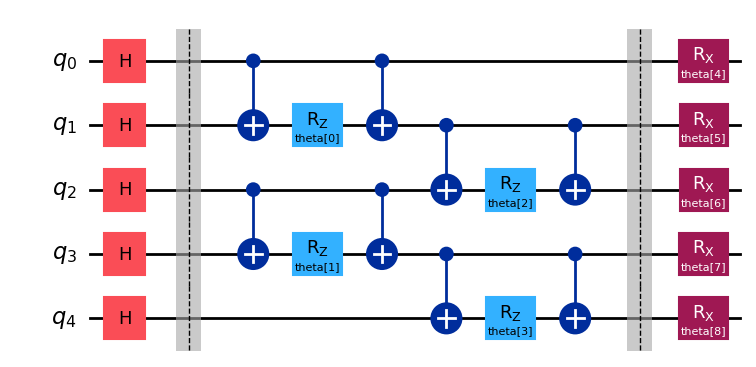

In [272]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

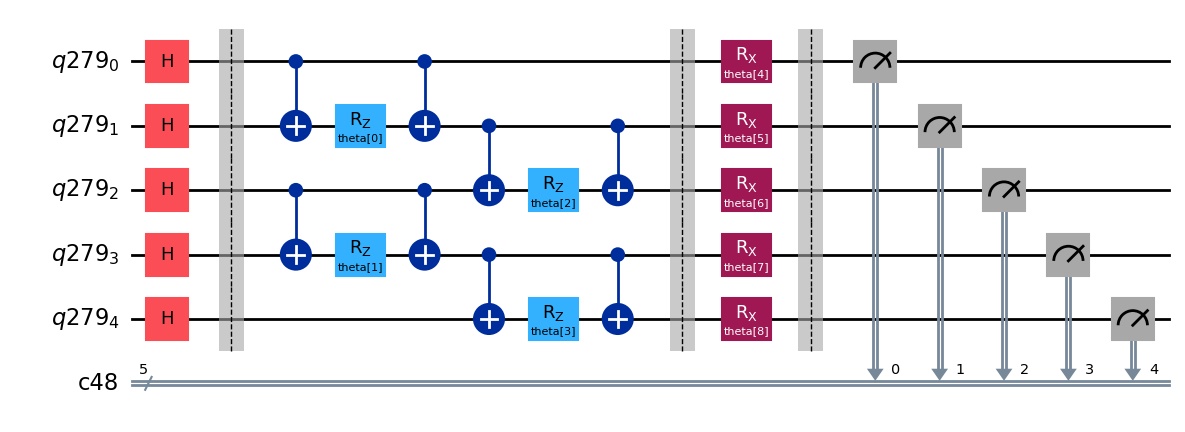

In [273]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

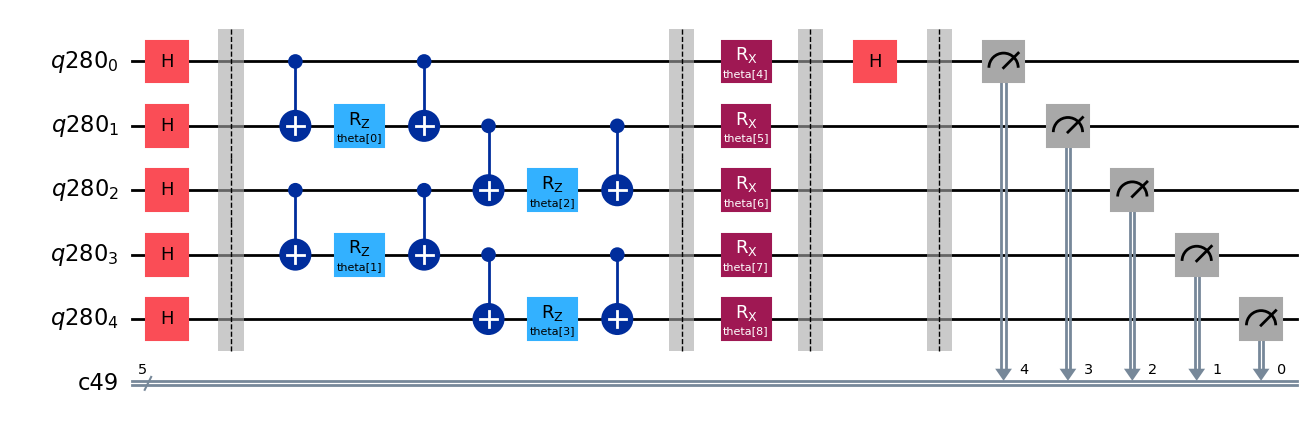

In [274]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

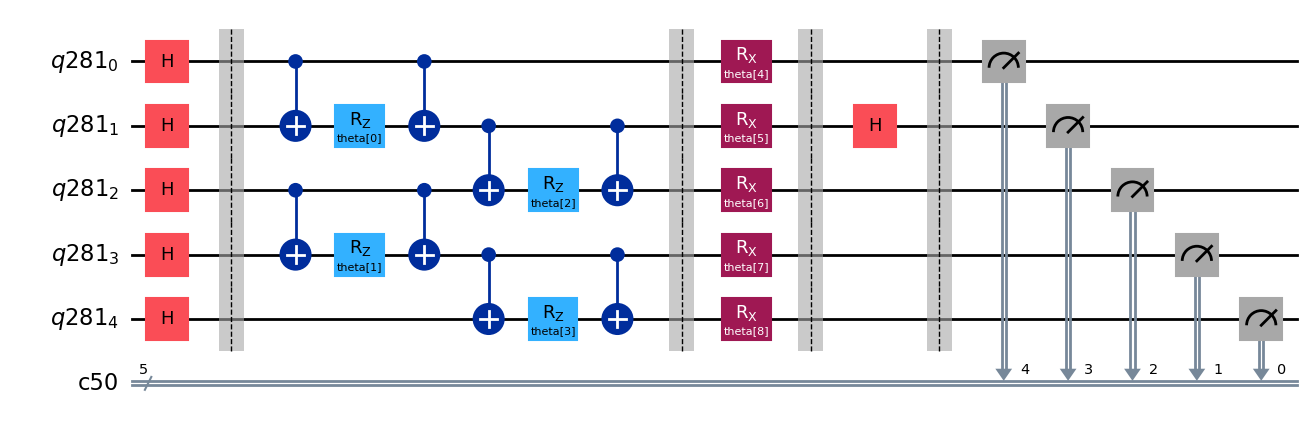

In [275]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

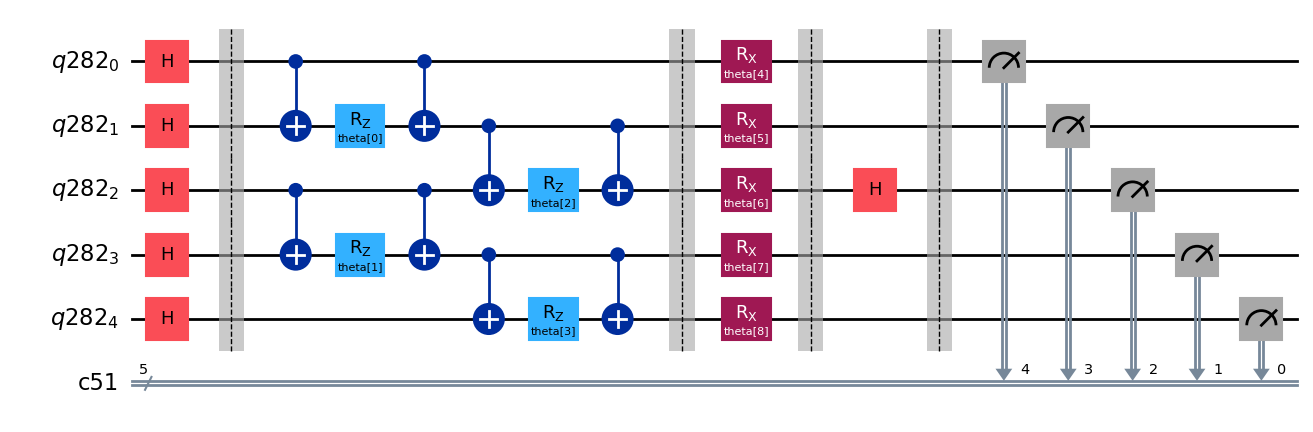

In [276]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

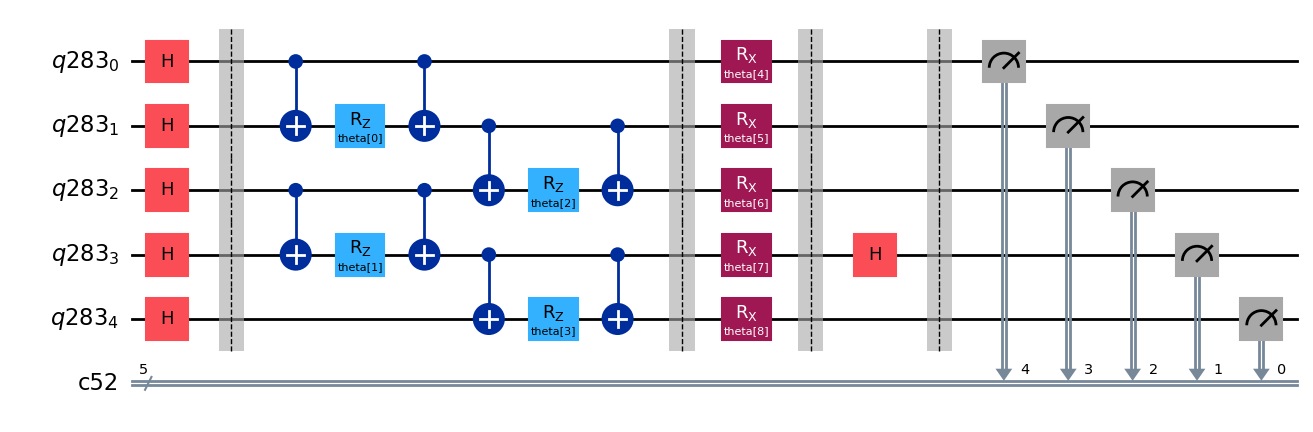

In [277]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

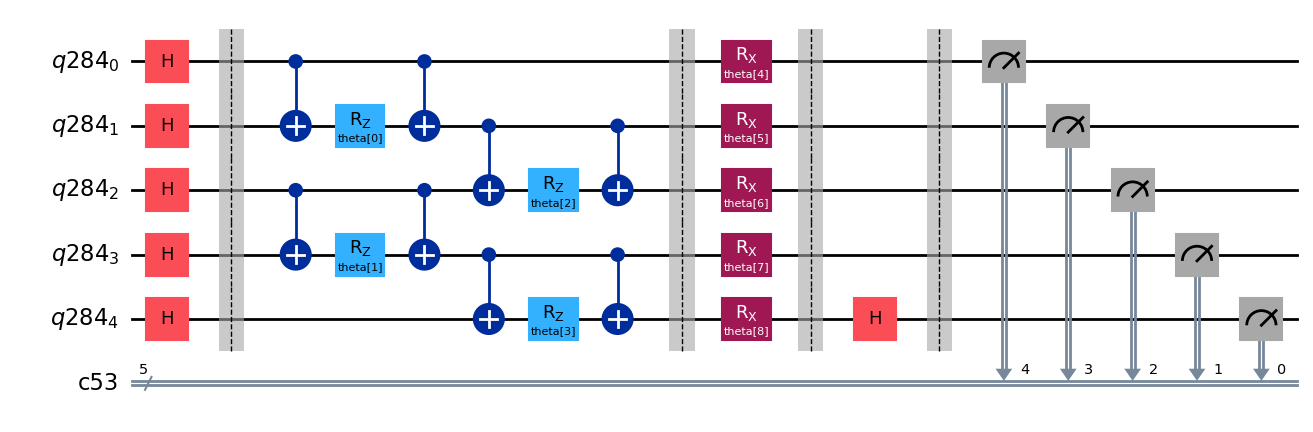

In [278]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [279]:
service = QiskitRuntimeService()

backend = service.backend("ibm_cusco")
print(backend)

<IBMBackend('ibm_cusco')>


In [280]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuit_zz = pm.run(ansatz_zz)
isa_circuit_x0 = pm.run(ansatz_x0)
isa_circuit_x1 = pm.run(ansatz_x1)
isa_circuit_x2 = pm.run(ansatz_x2)
isa_circuit_x3 = pm.run(ansatz_x3)
isa_circuit_x4 = pm.run(ansatz_x4)


options = Options()
options.optimization_level = 3
options.resilience_level = 0

sampler = Sampler(backend=backend, options=options)

## Cost Function for VQNHE

In [319]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [320]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_zz, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x0, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x1, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x2, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x3, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x4, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [321]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string = {8: 0.017, 14: 0.020875, 21: 0.109, 19: 0.018375, 25: 0.036375, 5: 0.036375, 2: 0.023, 13: 0.080375, 24: 0.01125, 3: 0.0065, 9: 0.074625, 22: 0.065625, 27: 0.01525, 1: 0.00725, 20: 0.024875, 10: 0.14, 0: 0.001375, 11: 0.03475, 23: 0.016875, 7: 0.005875, 15: 0.007375, 4: 0.00825, 16: 0.005125, 18: 0.07525, 17: 0.01825, 28: 0.00575, 31: 0.00275, 26: 0.058125, 12: 0.01675, 6: 0.0175, 30: 0.00725, 29: 0.032}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string = {8: 0.017, 14: 0.020875, 21: 0.109, 19: 0.018375, 25: 0.036375, 5: 0.036375, 2: 0.023, 13: 0.080375, 24: 0.01125, 3: 0.0065, 9: 0.074625, 22: 0.065625, 27: 0.01525, 1: 0.00725, 20: 0.024875, 10: 0.14, 0: 0.001375, 11: 0.03475, 23: 0.016875, 7: 0.005875, 15: 0.007375, 4: 0.00825, 16: 0.005125, 18: 0.07525, 17: 0.01825, 28: 0.00575, 31: 0.00275, 26: 0.058125, 12: 0.01675, 6: 0.0175, 30: 0.00725, 29: 0.032}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string = {8: 0.017, 14: 0.020875, 21: 0.109, 19: 0.018375, 25: 0.036375, 5: 0.036375, 2: 0.023, 13: 0.080375, 24: 0.01125, 3: 0.0065, 9: 0.074625, 22: 0.065625, 27: 0.01525, 1: 0.00725, 20: 0.024875, 10: 0.14, 0: 0.001375, 11: 0.03475, 23: 0.016875, 7: 0.005875, 15: 0.007375, 4: 0.00825, 16: 0.005125, 18: 0.07525, 17: 0.01825, 28: 0.00575, 31: 0.00275, 26: 0.058125, 12: 0.01675, 6: 0.0175, 30: 0.00725, 29: 0.032}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string = {8: 0.017, 14: 0.020875, 21: 0.109, 19: 0.018375, 25: 0.036375, 5: 0.036375, 2: 0.023, 13: 0.080375, 24: 0.01125, 3: 0.0065, 9: 0.074625, 22: 0.065625, 27: 0.01525, 1: 0.00725, 20: 0.024875, 10: 0.14, 0: 0.001375, 11: 0.03475, 23: 0.016875, 7: 0.005875, 15: 0.007375, 4: 0.00825, 16: 0.005125, 18: 0.07525, 17: 0.01825, 28: 0.00575, 31: 0.00275, 26: 0.058125, 12: 0.01675, 6: 0.0175, 30: 0.00725, 29: 0.032}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [322]:
def X0(params_nn, x_pqc_0):
  prob_string = {11: 0.064, 5: 0.118875, 26: 0.024, 19: 0.007125, 18: 0.014625, 2: 0.079, 12: 0.018625, 10: 0.15225, 20: 0.007125, 29: 0.013125, 30: 0.005375, 31: 0.00225, 9: 0.0745, 0: 0.007, 16: 0.001875, 14: 0.024125, 8: 0.02575, 7: 0.027625, 6: 0.075625, 21: 0.0235, 25: 0.01475, 15: 0.01, 24: 0.006125, 28: 0.002875, 4: 0.03375, 22: 0.016125, 1: 0.021375, 27: 0.012875, 13: 0.06625, 3: 0.0395, 23: 0.00475, 17: 0.00525}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = {13: 0.007875, 7: 0.011875, 23: 0.019, 3: 0.0515, 14: 0.00325, 25: 0.002125, 1: 0.055625, 8: 0.009625, 5: 0.084, 15: 0.001875, 10: 0.033125, 22: 0.056125, 28: 0.008125, 27: 0.00525, 2: 0.128375, 19: 0.04175, 16: 0.013, 4: 0.026, 11: 0.014, 18: 0.09875, 24: 0.000875, 17: 0.0375, 21: 0.105625, 30: 0.022875, 26: 0.007, 9: 0.027375, 29: 0.0265, 12: 0.00225, 20: 0.029125, 6: 0.038875, 0: 0.020375, 31: 0.010375}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = {5: 0.006375, 14: 0.03475, 30: 0.005375, 8: 0.043875, 16: 0.03475, 13: 0.004125, 15: 0.01575, 11: 0.0525, 10: 0.128625, 18: 0.155125, 6: 0.00175, 25: 0.028625, 0: 0.0075, 17: 0.107875, 3: 0.015, 29: 0.001625, 31: 0.004875, 1: 0.027125, 21: 0.02125, 12: 0.001375, 24: 0.01075, 9: 0.132, 22: 0.005375, 23: 0.00375, 4: 0.001, 27: 0.01475, 20: 0.006125, 7: 0.0015, 19: 0.055875, 2: 0.03525, 28: 0.00025, 26: 0.035125}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = {10: 0.033125, 15: 0.018875, 23: 0.026, 25: 0.03175, 26: 0.00975, 4: 0.02125, 2: 0.00725, 19: 0.009375, 21: 0.11025, 9: 0.12225, 12: 0.03375, 1: 0.013, 18: 0.026625, 0: 0.016375, 5: 0.026625, 14: 0.00625, 20: 0.089625, 27: 0.002625, 30: 0.001125, 3: 0.002375, 31: 0.00575, 16: 0.055875, 13: 0.051375, 22: 0.016875, 8: 0.13025, 6: 0.003375, 24: 0.03375, 17: 0.0505, 11: 0.01375, 29: 0.0145, 28: 0.0095, 7: 0.00625}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = {27: 0.003875, 19: 0.005375, 2: 0.032125, 0: 0.00675, 3: 0.001875, 6: 0.0215, 14: 0.030625, 8: 0.08725, 22: 0.093625, 12: 0.07075, 5: 0.003375, 24: 0.020375, 11: 0.01125, 31: 0.000125, 20: 0.13125, 28: 0.018375, 9: 0.009375, 7: 0.003125, 26: 0.04575, 1: 0.001125, 10: 0.1835, 16: 0.025, 25: 0.002625, 18: 0.102125, 13: 0.00875, 21: 0.016, 30: 0.01125, 4: 0.03425, 29: 0.00325, 15: 0.00325, 17: 0.002125, 23: 0.01}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [323]:
def norm(params_nn, x_pqc_0):
  prob_string = prob_string = {8: 0.017, 14: 0.020875, 21: 0.109, 19: 0.018375, 25: 0.036375, 5: 0.036375, 2: 0.023, 13: 0.080375, 24: 0.01125, 3: 0.0065, 9: 0.074625, 22: 0.065625, 27: 0.01525, 1: 0.00725, 20: 0.024875, 10: 0.14, 0: 0.001375, 11: 0.03475, 23: 0.016875, 7: 0.005875, 15: 0.007375, 4: 0.00825, 16: 0.005125, 18: 0.07525, 17: 0.01825, 28: 0.00575, 31: 0.00275, 26: 0.058125, 12: 0.01675, 6: 0.0175, 30: 0.00725, 29: 0.032}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [324]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [325]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Opmitizing Parameters in NN for 10 times

In [ ]:
local_minimum_list = []

for k in range(10):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  x_pqc_0 = np.array([-5.497e-01,  6.701e+00,  6.719e+00,  5.781e+00,  4.499e+00,  3.260e+00,  1.411e+00,  3.240e+00,  4.786e+00])

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 300
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [ ]:
local_minimum_list

## Optimized Parameters

In [ ]:
# PQC optimized parameter (just reuse parameters optimized by noiseless simulator)

op_param_pqc = np.array([4.072e-01, 5.925e+00, 3.793e-01, 4.251e-01, 4.988e+00, 5.968e+00, 5.033e+00, 2.907e+00, 1.807e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([ 0.57870729, -0.87649895,  0.47926301,  0.3567993 ,  0.08011762,
       -0.55040671, -0.60387427,  0.39284913, -0.66177833, -0.82332037,
        0.36812884,  1.02058556, -0.54684153, -0.17332772,  0.68468529,
       -0.62007687,  0.19667554, -0.60665658,  0.61685163,  0.14125764,
        0.54141079, -0.63755296, -0.46571464,  0.61434159, -0.01506   ,
        0.45485456,  0.48736403, -0.16972269,  0.65334736, -0.12378117,
        0.44521403, -0.39790144,  0.52049019, -0.38906325, -0.98397   ,
       -0.32312634, -0.66654454,  0.53832119, -0.90616722, -0.00468233,
       -0.56731673,  0.75105583, -0.70349332,  1.23372141,  0.03239518,
        0.84291864, -0.60947001,  0.60073067, -0.49497247, -0.48396261,
       -0.11559602, -0.81307925,  0.54931677, -0.71720018, -0.17714926,
        0.94536207,  1.00072618, -0.10387694,  0.68887493, -0.41405939,
        0.14093816,  0.78457027,  0.08300545,  0.13344488, -0.90886007,
       -0.31333669, -0.86969877, -0.40124539, -0.46693994,  0.49999776,
       -0.97009284, -0.1438797 , -0.15787296,  0.27672756, -0.35716167,
       -0.96087232,  0.60942993,  0.41104357,  0.83401726, -0.24828949,
        0.21316483,  0.02693325,  0.26235271, -0.43006342, -0.3975835 ,
       -0.95736662, -0.39483708, -0.51385064,  0.15345618,  0.13895689,
        0.08739339, -0.37847523, -0.95354712,  0.96034828, -0.38385302,
       -0.1509879 ,  0.91229852,  0.01672284, -0.4740495 ,  0.10604523,
        0.13462491,  0.6829069 , -0.81942867, -0.08089784,  0.58400099,
        0.49640951,  0.16533603, -0.94874934, -0.28962644,  0.21051989,
       -0.38667225,  0.02466831,  0.42402663, -0.70431661, -0.91706035,
       -0.27199539, -0.74474387, -0.63906023,  0.76523494, -0.29416423,
       -0.53586857,  0.50499234, -0.78164574,  0.4875594 , -0.06207505,
        0.25503815, -0.71183973, -0.63735857,  0.35745457, -0.90278202,
       -0.30869043,  0.09748999, -0.58536797, -0.30180758,  0.84029307,
        0.71804922,  0.15190558,  0.02334323, -0.91571651,  0.902236  ,
        0.12777793,  0.58351399,  0.00959704,  0.73840828,  0.19817079,
        0.46587381, -0.77410197, -0.35952663,  0.37948824, -0.77857938,
       -0.36515776, -0.6675957 ,  0.47908297,  0.58570418, -0.88639574,
        0.61837118,  0.29728136,  0.25997525, -0.4697403 , -0.19598501,
       -0.32095145, -0.92488465, -0.62827136,  0.26170006,  0.5294389 ,
        0.09908167, -0.21424412, -0.69530033,  0.85073637,  0.29142435,
        0.54441923,  0.70973302,  0.20059565,  0.49251921,  0.19684267,
       -0.98816821,  0.51763718, -0.64455802, -0.23195246,  0.02313815,
       -0.1388649 ,  0.68003136, -0.61355539, -0.93336731,  0.63056003,
        0.37079422, -0.19716911, -0.23905544, -0.80065243, -0.54262913,
       -0.81079525,  0.4275661 , -0.84582919, -0.58812377,  0.1425216 ,
       -0.4328633 ,  0.30665239,  0.5248975 , -0.29757299, -0.83469557,
        0.44714306,  0.54122983, -0.00636053,  0.70744015, -0.27906985,
       -0.50078806,  0.66486708,  0.64779452,  0.00972129,  0.23494056,
       -0.62079235,  0.7914179 ,  1.00273925, -0.38623771,  0.68175058,
       -0.47006871, -0.82944454, -0.81395575, -0.83450941, -0.87530676,
       -0.63747605,  0.83016234, -0.10576004, -0.73881555,  0.59934493,
       -0.23935653, -0.91368679,  0.26183399, -0.45141036,  0.38747073,
       -0.31437027,  0.6133833 ,  0.74937615,  0.1115995 ,  0.10207668,
       -0.66972379, -0.37508816, -0.2011044 ,  0.10294305,  0.66260626,
       -0.33364475, -0.20711624,  0.49543   , -0.19044295, -0.56486342,
        0.61437225,  0.01838807, -0.90480604,  0.97248329, -0.56970286,
       -0.36016782, -0.25998788,  0.47291479,  0.26135328,  0.68240248,
       -0.41080126, -0.40108191,  0.25836566,  0.38443813,  0.45518531,
       -0.65227274, -0.61902111,  0.0390273 ,  0.93207858,  0.28387936,
       -0.6200652 , -0.86334406,  0.59152542,  0.5353457 ,  0.38574368,
        1.70133248])

## Plot Result of VQNHE in IBM Hardware (IBM CUSCO, resilience_level=0)

VQNHE Lowest Energy Configuration for 100 times

[-5.77848119, -5.77848119, -5.71289339, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119]

VQE Lowest Energy Configuration for 100 times

[-5.06079102, -5.26391602, -5.17651367, -5.2253418 , -5.31274414, -5.31054688, -5.2878418 , -5.27050781, -5.28540039, -5.29614258]

In [ ]:
vqnhe_minimum_list = np.array([-5.77848119, -5.77848119, -5.71289339, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119])

In [ ]:
vqe_minimum_list = np.array([-5.06079102, -5.26391602, -5.17651367, -5.2253418 , -5.31274414, -5.31054688, -5.2878418 , -5.27050781, -5.28540039, -5.29614258])

In [ ]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -5.8948130873
variance : 0.004279121675433017
maximum : -5.7362738
minimum : -5.94158525

[-5.8392458  -5.87546176 -5.83924655 -5.8402692  -5.94158523 -5.8751673
 -5.94158524 -5.94158525 -5.94158523 -5.78074357 -5.94158524 -5.94158525
 -5.94158524 -5.77757292 -5.94145631 -5.93439034 -5.91385498 -5.94158136
 -5.94158525 -5.77810274 -5.780743   -5.941585   -5.941585   -5.941585
 -5.941503   -5.94158525 -5.78074364 -5.87516718 -5.88974625 -5.94158525
 -5.9415852  -5.93299599 -5.94158524 -5.90888822 -5.9316028  -5.94158525
 -5.9380279  -5.80099864 -5.7535819  -5.77514423 -5.90469022 -5.94158524
 -5.94158523 -5.94158525 -5.83924657 -5.94158524 -5.93917358 -5.94154199
 -5.84026916 -5.77825212 -5.93705511 -5.78074338 -5.94156212 -5.94158525
 -5.93272868 -5.94158525 -5.94158525 -5.86214847 -5.941585   -5.77816882
 -5.81901766 -5.94148885 -5.82826786 -5.83924583 -5.77273822 -5.94158524
 -5.84258761 -5.94158525 -5.9415604  -5.93799288 -5.9415426  -5.94158525
 -5.94158525 -5.94158525 -5.93

In [ ]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.6661791994
variance : 0.006554347254818564
maximum : -5.34375
minimum : -5.77734375

[-5.60742188 -5.76147461 -5.60180664 -5.70556641 -5.69165039 -5.76611328
 -5.65112305 -5.64379883 -5.53466797 -5.55786133 -5.57275391 -5.75830078
 -5.77734375 -5.59106445 -5.60424805 -5.71679688 -5.4831543  -5.73168945
 -5.67578125 -5.73046875 -5.74951172 -5.77416992 -5.68432617 -5.6496582
 -5.51489258 -5.70556641 -5.6237793  -5.66503906 -5.71142578 -5.68334961
 -5.71533203 -5.74560547 -5.71630859 -5.34375    -5.70336914 -5.70239258
 -5.70874023 -5.73583984 -5.57202148 -5.56396484 -5.6862793  -5.63623047
 -5.56738281 -5.60766602 -5.6418457  -5.69580078 -5.55810547 -5.74438477
 -5.72167969 -5.72680664 -5.67480469 -5.61572266 -5.42407227 -5.51489258
 -5.67822266 -5.74609375 -5.69677734 -5.66601562 -5.73046875 -5.57861328
 -5.55273438 -5.76977539 -5.69750977 -5.70141602 -5.6484375  -5.73706055
 -5.7121582  -5.77319336 -5.60473633 -5.68017578 -5.64233398 -5.59057617
 -5.74365234 -5.67236328 -5.60

# VQNHE in IBM Hardware (IBM CUSCO, resilience_level=1)

optimization_level=3 & resilience_level=1

use parameter optimized in Noiseless Simulator & just conduct neural net parameter optimizaion for 10 times

## Ansatz, Hamiltonian, Sampler & Estimator Setting

In [248]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Options
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [249]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

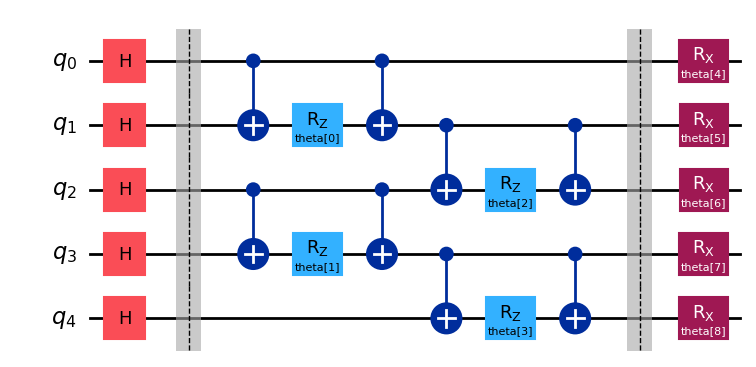

In [250]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

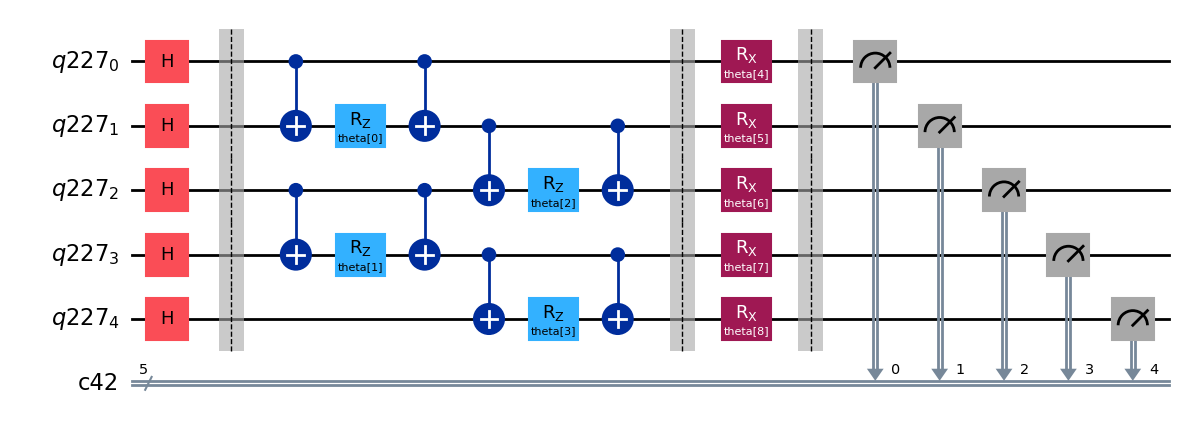

In [251]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

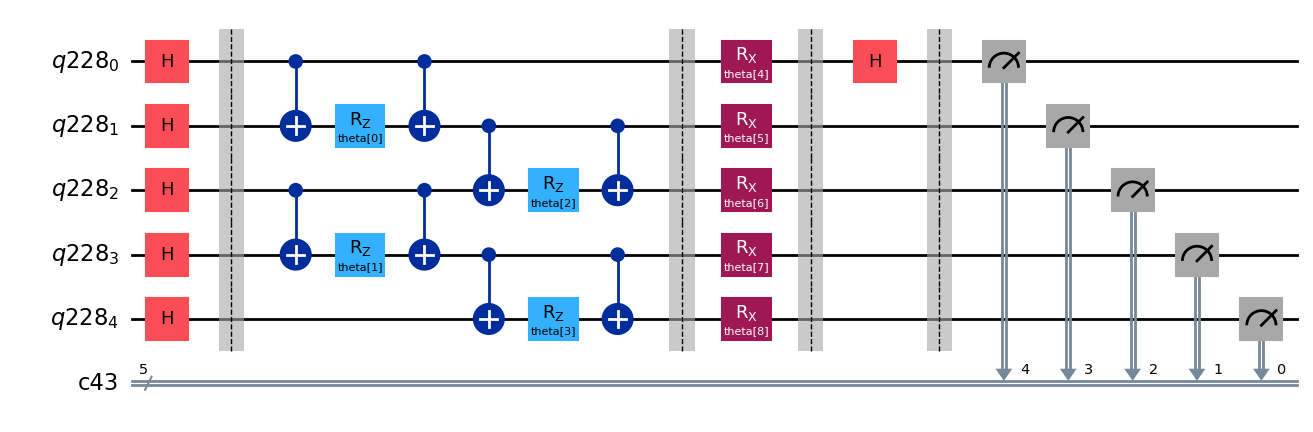

In [252]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

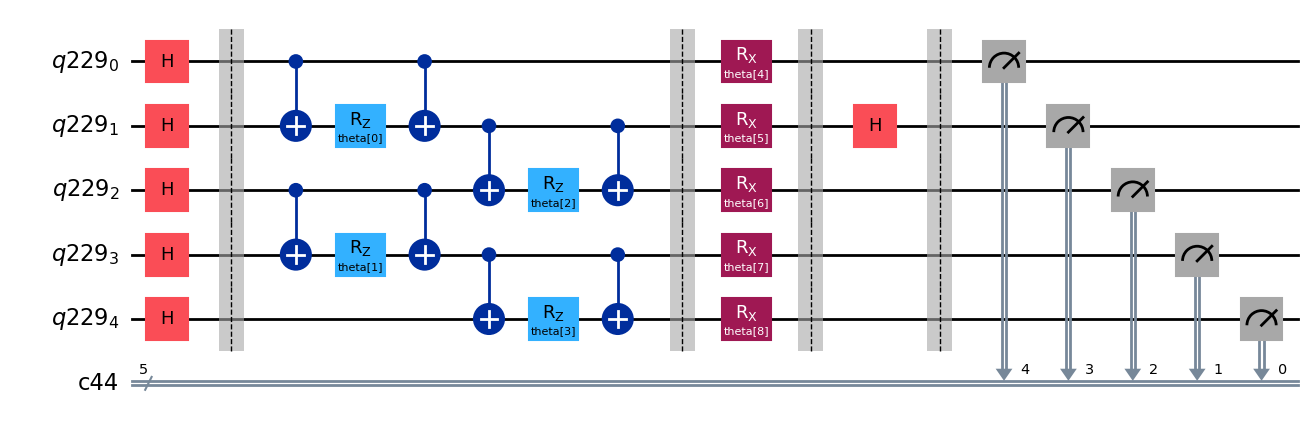

In [253]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

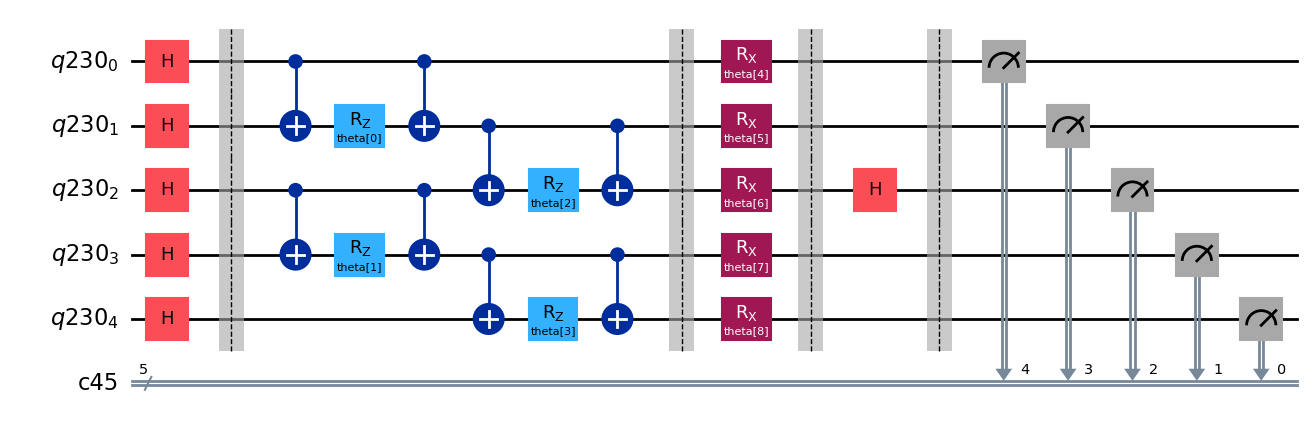

In [254]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

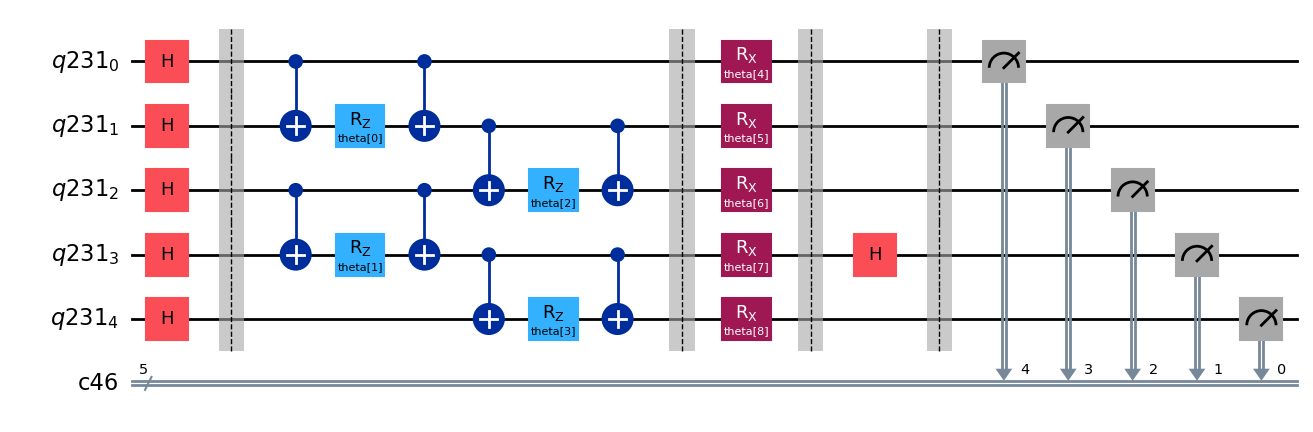

In [255]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

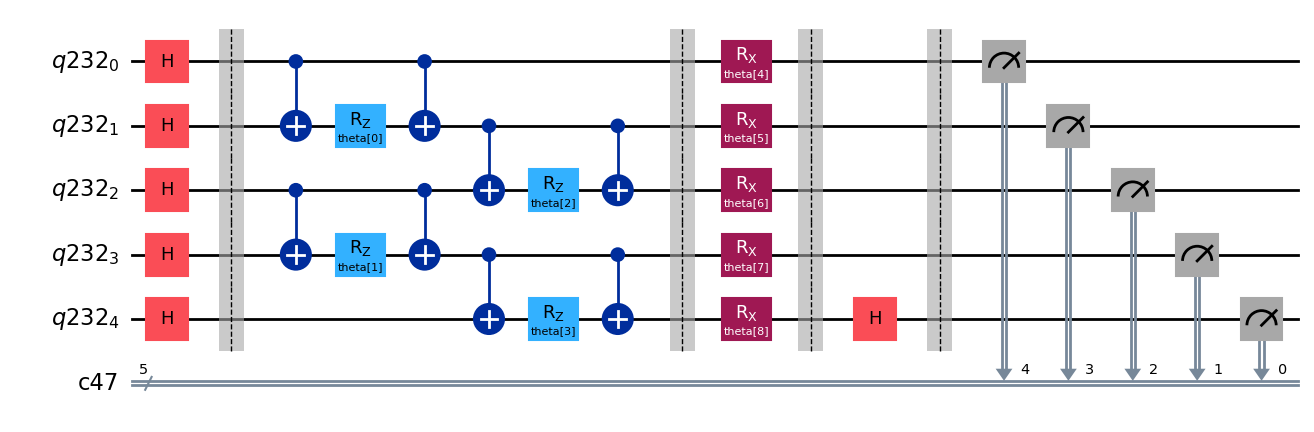

In [256]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [257]:
service = QiskitRuntimeService()

backend = service.backend("ibm_cusco")
print(backend)

<IBMBackend('ibm_cusco')>


In [258]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuit_zz = pm.run(ansatz_zz)
isa_circuit_x0 = pm.run(ansatz_x0)
isa_circuit_x1 = pm.run(ansatz_x1)
isa_circuit_x2 = pm.run(ansatz_x2)
isa_circuit_x3 = pm.run(ansatz_x3)
isa_circuit_x4 = pm.run(ansatz_x4)


options = Options()
options.optimization_level = 3
options.resilience_level = 0

sampler = Sampler(backend=backend, options=options)

## Cost Function for VQNHE

In [259]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:50]
  W2 = parameter[50:250]
  W3 = parameter[250:270]
  c = parameter[270]

  W1 = W1.reshape(10,5)
  W2 = W2.reshape(20,10)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [260]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_zz, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x0, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x1, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x2, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x3, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])
  job = sampler.run(isa_circuit_x4, params_pqc, shots=8000).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [261]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = {0: 0.000703318749639, 1: 0.00279701230776, 2: 0.018962583903367, 3: 0.004633930511633, 4: 0.006873627806736, 5: 0.033051991418439, 6: 0.019247714308425, 7: 0.005906259179086, 8: 0.015282054058638, 9: 0.084477253768211, 10: 0.147913247730329, 11: 0.033322767782439, 12: 0.015974756754199, 13: 0.078755517519148, 14: 0.025803949922671, 15: 0.009556648531217, 16: 0.003014439712155, 17: 0.021196278884722, 18: 0.07334858435814, 19: 0.01789682068835, 20: 0.027081690130632, 21: 0.128669683874592, 22: 0.071120033379857, 23: 0.021254392687701, 24: 0.005067797516043, 25: 0.035538049235404, 26: 0.053010842498968, 27: 0.01443383641633, 28: 0.003419917110751, 29: 0.017811049699612, 30: 0.002038596308552, 31: 0.001835353246256}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = {0: 0.000703318749639, 1: 0.00279701230776, 2: 0.018962583903367, 3: 0.004633930511633, 4: 0.006873627806736, 5: 0.033051991418439, 6: 0.019247714308425, 7: 0.005906259179086, 8: 0.015282054058638, 9: 0.084477253768211, 10: 0.147913247730329, 11: 0.033322767782439, 12: 0.015974756754199, 13: 0.078755517519148, 14: 0.025803949922671, 15: 0.009556648531217, 16: 0.003014439712155, 17: 0.021196278884722, 18: 0.07334858435814, 19: 0.01789682068835, 20: 0.027081690130632, 21: 0.128669683874592, 22: 0.071120033379857, 23: 0.021254392687701, 24: 0.005067797516043, 25: 0.035538049235404, 26: 0.053010842498968, 27: 0.01443383641633, 28: 0.003419917110751, 29: 0.017811049699612, 30: 0.002038596308552, 31: 0.001835353246256}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = {0: 0.000703318749639, 1: 0.00279701230776, 2: 0.018962583903367, 3: 0.004633930511633, 4: 0.006873627806736, 5: 0.033051991418439, 6: 0.019247714308425, 7: 0.005906259179086, 8: 0.015282054058638, 9: 0.084477253768211, 10: 0.147913247730329, 11: 0.033322767782439, 12: 0.015974756754199, 13: 0.078755517519148, 14: 0.025803949922671, 15: 0.009556648531217, 16: 0.003014439712155, 17: 0.021196278884722, 18: 0.07334858435814, 19: 0.01789682068835, 20: 0.027081690130632, 21: 0.128669683874592, 22: 0.071120033379857, 23: 0.021254392687701, 24: 0.005067797516043, 25: 0.035538049235404, 26: 0.053010842498968, 27: 0.01443383641633, 28: 0.003419917110751, 29: 0.017811049699612, 30: 0.002038596308552, 31: 0.001835353246256}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = {0: 0.000703318749639, 1: 0.00279701230776, 2: 0.018962583903367, 3: 0.004633930511633, 4: 0.006873627806736, 5: 0.033051991418439, 6: 0.019247714308425, 7: 0.005906259179086, 8: 0.015282054058638, 9: 0.084477253768211, 10: 0.147913247730329, 11: 0.033322767782439, 12: 0.015974756754199, 13: 0.078755517519148, 14: 0.025803949922671, 15: 0.009556648531217, 16: 0.003014439712155, 17: 0.021196278884722, 18: 0.07334858435814, 19: 0.01789682068835, 20: 0.027081690130632, 21: 0.128669683874592, 22: 0.071120033379857, 23: 0.021254392687701, 24: 0.005067797516043, 25: 0.035538049235404, 26: 0.053010842498968, 27: 0.01443383641633, 28: 0.003419917110751, 29: 0.017811049699612, 30: 0.002038596308552, 31: 0.001835353246256}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [262]:
def X0(params_nn, x_pqc_0):
  prob_string = {0: 0.003221811027989, 1: 0.013720616607772, 2: 0.086509256563204, 3: 0.036657684254791, 4: 0.036851539207174, 5: 0.132336211992661, 6: 0.086510177502053, 7: 0.019456222579804, 8: 0.019908390820414, 9: 0.084012670068013, 10: 0.155720273031997, 11: 0.058918039723108, 12: 0.020277542790899, 13: 0.074326909414564, 14: 0.025308385991938, 15: 0.002242411916342, 16: 0.001637015918755, 17: 0.004710222502895, 18: 0.014038555804261, 19: 0.005763238520121, 20: 0.006376109193768, 21: 0.02155167492152, 22: 0.016546287580242, 23: 0.002591475456268, 24: 0.003118388526951, 25: 0.014297143039318, 26: 0.026846106013901, 27: 0.007362223417038, 28: 0.002164938015832, 29: 0.013575827007872, 30: 0.004195509870448, 31: -0.000752859281911}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = {0: 0.011977035825877, 1: 0.054670380111213, 2: 0.123072791595097, 3: 0.053347430824717, 4: 0.027486486492606, 5: 0.084921824942258, 6: 0.037471836290944, 7: 0.004450144442216, 8: 0.006508221437441, 9: 0.027015776361831, 10: 0.041200660345334, 11: 0.011162152190057, 12: 0.001123986388839, 13: 0.008896389337426, 14: 0.001661698814345, 15: 0.000710916273382, 16: 0.004420758494502, 17: 0.031506206535213, 18: 0.110379543664659, 19: 0.042686425862813, 20: 0.033645856673674, 21: 0.118394666799603, 22: 0.067571482515778, 23: 0.015678836597682, 24: 0.00037837323437, 25: 0.001468119632076, 26: 0.005405130192067, 27: 0.005057014075737, 28: 0.007026313558884, 29: 0.027955581344398, 30: 0.025491163597307, 31: 0.007256795547655}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = {0: 0.005282933278883, 1: 0.01993906139512, 2: 0.027523129635907, 3: 0.009159904278638, 4: 0.001573002510403, 5: 0.006507161208012, 6: 0.001154281393279, 7: -0.000285973366993, 8: 0.037317198411997, 9: 0.144886819394272, 10: 0.143467816117002, 11: 0.046673017145909, 12: -0.001172097988139, 13: 0.002322630544133, 14: 0.029642732974481, 15: 0.014712648059518, 16: 0.027997251427989, 17: 0.122244882616824, 18: 0.1692654696734, 19: 0.052722392387707, 20: 0.006242960692993, 21: 0.029477706815936, 22: 0.004430533247875, 23: -0.000321881549827, 24: 0.00905195245726, 25: 0.034993438427492, 26: 0.036710851727247, 27: 0.007867490567011, 28: 0.00014171220839, 29: 0.000571602761839, 30: 0.006291367709679, 31: 0.003608003835763}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = {0: 0.013816803643351, 1: 0.008945967483496, 2: 0.004231862369942, 3: 0.002582877114321, 4: 0.020323851578378, 5: 0.023816083653228, 6: 0.000983498547864, 7: 0.003283185803265, 8: 0.143757704139556, 9: 0.133246103089198, 10: 0.026406924853574, 11: 5.1030394025e-05, 12: 0.039464366344011, 13: 0.056328298790837, 14: 0.004027848453954, 15: 0.016686973895251, 16: 0.066952494041105, 17: 0.043750134394816, 18: 0.022091271436542, 19: 0.005121955054714, 20: 0.107614175200512, 21: 0.129712747195766, 22: 0.005902967771908, 23: 0.017061580797712, 24: 0.036698223940381, 25: 0.033019480776423, 26: 0.004171387158284, 27: 5.6139065587e-05, 28: 0.009301715948812, 29: 0.015213992405585, 30: 0.001111290656751, 31: 0.00426706400085}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = {0: 0.003594406646332, 1: 0.000513212292546, 2: 0.020828539319794, 3: 0.000927284400272, 4: 0.026048041615957, 5: 0.002738799523693, 6: 0.016495573058347, 7: 0.001621984259424, 8: 0.087521918457948, 9: 0.007481327383269, 10: 0.191312841085814, 11: 0.011304603931524, 12: 0.084692725500229, 13: 0.007783186764485, 14: 0.026801155007262, 15: 0.001596389865696, 16: 0.02065778974128, 17: 0.001145954496247, 18: 0.114352292640459, 19: 0.005879175221076, 20: 0.151845347733109, 21: 0.013206866310172, 22: 0.096192368049312, 23: 0.006325939970753, 24: 0.019002721597875, 25: 0.001461320965182, 26: 0.047350825217436, 27: 0.002738617223706, 28: 0.01862248265062, 29: 0.002876745991063, 30: 0.006586876122208, 31: 0.000492686956913}
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval

In [263]:
def norm(params_nn, x_pqc_0):
  prob_string = {0: 0.000703318749639, 1: 0.00279701230776, 2: 0.018962583903367, 3: 0.004633930511633, 4: 0.006873627806736, 5: 0.033051991418439, 6: 0.019247714308425, 7: 0.005906259179086, 8: 0.015282054058638, 9: 0.084477253768211, 10: 0.147913247730329, 11: 0.033322767782439, 12: 0.015974756754199, 13: 0.078755517519148, 14: 0.025803949922671, 15: 0.009556648531217, 16: 0.003014439712155, 17: 0.021196278884722, 18: 0.07334858435814, 19: 0.01789682068835, 20: 0.027081690130632, 21: 0.128669683874592, 22: 0.071120033379857, 23: 0.021254392687701, 24: 0.005067797516043, 25: 0.035538049235404, 26: 0.053010842498968, 27: 0.01443383641633, 28: 0.003419917110751, 29: 0.017811049699612, 30: 0.002038596308552, 31: 0.001835353246256}
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [264]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [265]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Opmitizing Parameters in VQNHE for 10 times

In [267]:
local_minimum_list = []

for k in range(10):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.random.random(271) - 1

  x_pqc_0 = np.array([-5.497e-01,  6.701e+00,  6.719e+00,  5.781e+00,  4.499e+00,  3.260e+00,  1.411e+00,  3.240e+00,  4.786e+00])

  callback = build_callback_vqnhe(x_pqc_0, callback_dict)

  options = dict()
  options["maxiter"] = 300
  options["disp"] = True

  res = minimize(
    cost_func_vqnhe,
    x0,
    args=(x_pqc_0),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

Optimization terminated successfully.
         Current function value: -6.203877
         Iterations: 135
         Function evaluations: 41344
         Gradient evaluations: 152
         Current function value: -6.199077
         Iterations: 300
         Function evaluations: 102000
         Gradient evaluations: 375
Optimization terminated successfully.
         Current function value: -6.203877
         Iterations: 133
         Function evaluations: 39440
         Gradient evaluations: 145
Optimization terminated successfully.
         Current function value: -6.194743
         Iterations: 148
         Function evaluations: 46240
         Gradient evaluations: 170
Optimization terminated successfully.
         Current function value: -5.904383
         Iterations: 134
         Function evaluations: 43792
         Gradient evaluations: 161
Optimization terminated successfully.
         Current function value: -5.900059
         Iterations: 107
         Function evaluations: 38896
    

In [268]:
local_minimum_list

array([-6.20387731, -6.19907682, -6.20387731, -6.19474288, -5.90438281,
       -5.90005932, -6.20387731, -6.20387731, -6.20387731, -5.75011618])

## Optimized Parameters

In [ ]:
# PQC optimized parameter (just reuse parameters optimized by noiseless simulator)

op_param_pqc = np.array([4.072e-01, 5.925e+00, 3.793e-01, 4.251e-01, 4.988e+00, 5.968e+00, 5.033e+00, 2.907e+00, 1.807e+00])

In [ ]:
## NN optimized parameter

op_param_nn = np.array([-0.97925169, -0.0024826 , -0.00845341, -0.73234094, -0.71577783,
       -0.56288265, -0.16298364, -0.50379766, -0.8318807 , -0.30900272,
       -0.30779755,  0.18789984,  0.50314248, -2.01610819, -0.0522627 ,
        0.28459706,  0.49065057,  1.13584085,  0.93402648,  0.04941108,
       -0.4760355 ,  0.11700243,  0.75509147, -0.06802331,  1.14987541,
       -0.32722267,  2.02701802, -1.22093257,  0.73005927,  1.42727471,
        1.47456821,  0.65902635,  1.22936243, -1.42719182, -0.55700674,
        0.1780156 ,  1.13811624,  1.13109541, -1.18695535,  0.09935433,
        1.7645976 , -0.87108621,  0.05720991, -1.03543046,  1.5907936 ,
       -0.99750771,  0.75151221,  0.24127469,  0.6925094 , -1.18732841,
        0.29423343,  0.27610797, -0.07660468, -0.89388115, -0.92285815,
       -0.66093717,  0.58909577, -0.67478791, -0.7225226 , -0.29416609,
       -0.03100309,  0.39547277,  0.63573653, -0.47043817,  0.81434777,
       -0.96127886, -0.20968363, -0.57770364, -0.32867389, -0.10399554,
       -0.00372078, -0.17130735, -0.57148187, -0.65024894, -0.52982427,
        0.29771483, -0.12625509,  0.1321434 , -0.01284967, -0.19589238,
        0.46953163,  0.11243297, -0.38267437,  0.76907716, -0.57563754,
       -0.83663603,  0.3064056 ,  0.02306058, -0.60834255, -0.82693127,
        0.07915105, -0.42140144, -0.80507075, -0.25846023,  0.0067182 ,
       -0.9070747 , -0.05737424, -0.93295549,  0.57185971,  0.20541176,
       -0.47548321, -0.79828282,  0.72013338,  0.03838693, -0.70790442,
       -0.78364549,  0.53885063, -0.06159398, -0.49401836,  0.3116399 ,
       -0.37232424,  0.58324637, -0.06232942,  1.24905798,  0.19179147,
        0.50082501, -0.72150323,  0.09173146, -0.25324754,  0.62225716,
       -0.85353385,  0.672414  ,  0.89300566, -0.55156956, -1.02888657,
        0.78852271,  1.09427968,  1.22570542,  0.31620682,  1.28343415,
       -0.38316269, -0.32222007,  0.62972181, -0.42834435,  0.05964524,
        1.5112755 ,  1.32200669,  0.56211052,  1.40962944,  0.21351925,
       -0.39465863,  0.6575624 , -0.52292538,  1.33726028,  0.72541446,
       -0.45302475, -1.07273129,  0.90827465, -1.16019252,  0.63665958,
        0.3669407 , -0.07597912,  0.434266  , -0.27070244,  0.78864415,
       -0.58735613,  0.33432788,  0.10883273,  0.50973274, -0.27389915,
        0.90502231,  0.70651526,  0.79745932, -0.94863516, -0.68687958,
       -0.04619068,  0.46987346, -0.28697558,  0.12901468, -0.9090506 ,
        0.28091064,  0.36241276, -0.10863438, -0.64063918,  0.1799439 ,
        0.60447671,  0.44808352,  0.9383752 ,  0.40909061, -0.78458857,
        0.18350256, -0.89224451,  0.52152351, -0.37391579,  0.71761907,
        0.72238802, -0.01294512, -0.70175651,  0.83827071,  0.95642242,
        0.38914066,  0.33508892,  0.32906323,  0.69665971,  0.61322595,
       -0.58029465,  0.02824435,  0.60451779, -1.02758445, -0.29210266,
        0.52474036, -0.9162665 , -0.48647813,  0.12852904, -0.539207  ,
        0.99896994, -0.50293355, -0.54529035, -0.73479855,  0.49658979,
        0.86697088, -0.63378562, -0.37760287,  0.66143053, -0.77431883,
       -0.90904435, -0.29151212, -0.12169071,  0.14716419,  0.06028888,
       -0.33974565, -0.1486978 , -0.48647161, -0.27863095,  0.84325017,
       -0.77180981, -0.06409538, -0.64176086,  0.62169205,  0.98282355,
       -0.77045087,  0.44196342,  0.84933449, -0.12930973,  0.60720084,
        0.85824809, -0.99340721, -0.39194257, -0.93408033, -0.58678695,
       -0.97758431, -0.90220093,  0.22354806, -0.5360565 ,  0.54442906,
       -0.43323405,  0.67320913, -0.88649282,  0.00456854, -0.42611202,
        0.6123064 , -0.34025515, -0.71604148,  0.17876512, -0.22515297,
        0.04454726,  0.87332495, -2.10343999, -2.1418828 ,  2.00002075,
       -0.53975776, -0.40730807, -0.9330172 , -0.6074036 ,  0.20123435,
       -0.36356146,  0.43702069,  0.727343  ,  0.25140349,  0.1743658 ,
       -0.23468195])

## Plot Result of VQNHE in IBM Hardware (IBM CUSCO, resilience_level=1)

VQNHE Lowest Energy Configuration for 10 times

[-6.20387731, -6.19907682, -6.20387731, -6.19474288, -5.90438281, -5.90005932, -6.20387731, -6.20387731, -6.20387731, -5.75011618]

VQE Lowest Energy Configuration for 10 times

[-5.72749676, -5.72937777, -5.73962453, -5.7612482 , -5.68476149, -5.6843978 , -5.64541463, -5.76621523, -5.71810848, -5.76632458]

In [315]:
vqnhe_minimum_list = np.array([-6.20387731, -6.19907682, -6.20387731, -6.19474288, -5.90438281, -5.90005932, -6.20387731, -6.20387731, -6.20387731, -5.75011618])

In [316]:
vqe_minimum_list = np.array([-5.72749676, -5.72937777, -5.73962453, -5.7612482 , -5.68476149, -5.6843978 , -5.64541463, -5.76621523, -5.71810848, -5.76632458])

In [317]:
mean_vqnhe = np.mean(vqnhe_minimum_list)
var_vqnhe = np.var(vqnhe_minimum_list)
max_vqnhe = np.max(vqnhe_minimum_list)
min_vqnhe = np.min(vqnhe_minimum_list)

print("mean : {0}".format(mean_vqnhe))
print("variance : {0}".format(var_vqnhe))
print("maximum : {0}".format(max_vqnhe))
print("minimum : {0}".format(min_vqnhe))
print()
print(vqnhe_minimum_list)

mean : -6.096776456000001
variance : 0.027330204291713865
maximum : -5.75011618
minimum : -6.20387731

[-6.20387731 -6.19907682 -6.20387731 -6.19474288 -5.90438281 -5.90005932
 -6.20387731 -6.20387731 -6.20387731 -5.75011618]


In [318]:
mean_vqe = np.mean(vqe_minimum_list)
var_vqe = np.var(vqe_minimum_list)
max_vqe = np.max(vqe_minimum_list)
min_vqe = np.min(vqe_minimum_list)

print("mean : {0}".format(mean_vqe))
print("variance : {0}".format(var_vqe))
print("maximum : {0}".format(max_vqe))
print("minimum : {0}".format(min_vqe))
print()
print(vqe_minimum_list)

mean : -5.722296947
variance : 0.0014535559200360005
maximum : -5.64541463
minimum : -5.76632458

[-5.72749676 -5.72937777 -5.73962453 -5.7612482  -5.68476149 -5.6843978
 -5.64541463 -5.76621523 -5.71810848 -5.76632458]


# VQE, VQNHE Data & Figure

In [333]:
import numpy as np

vqe_noiseless = np.array([-5.82879886, -5.89649831, -5.89460313, -5.87216999, -5.89714665, -5.8970116, -5.82318112, -5.88723766, -5.87906279, -5.89633351, -5.89712631, -5.89706667, -5.89640049, -5.89686096, -5.84344741, -5.89722894, -5.89514208, -5.89722285, -5.89281514, -5.8954058 , -5.89660128, -5.89722463, -5.8262015 , -5.89560605, -5.83363386, -5.87957003, -5.82656423, -5.89196626, -5.82341307, -5.8972198 , -5.82579769, -5.89274968, -5.89058962, -5.89571965, -5.89121954, -5.89066143, -5.89556185, -5.8294686 , -5.89500158, -5.88381387, -5.89720651, -5.86661138, -5.89703354, -5.8971071 , -5.89488588, -5.88977925, -5.89321505, -5.89655454, -5.89722776, -5.89703659, -5.8961525 , -5.89248345, -5.89678098, -5.89358845, -5.82619791, -5.88964449, -5.89599961, -5.89636862, -5.87624267, -5.89717557, -5.89514411, -5.83231881, -5.89722489, -5.89417956, -5.86522879, -5.89603463, -5.82299708, -5.89690459, -5.89513546, -5.88945447, -5.89701515, -5.89144585, -5.89279627, -5.89577581, -5.836521 , -5.88388422, -5.89711739, -5.84467668, -5.89351984, -5.89512836, -5.89677164, -5.87800257, -5.88000114, -5.83970428, -5.88410124, -5.86785946, -5.8962536 , -5.89717338, -5.84988649, -5.892418 , -5.88143104, -5.89473968, -5.89702307, -5.85915542, -5.89705331, -5.89717653, -5.89196071, -5.89641764, -5.88954192, -5.89643247])

vqe_bitflip_1 = np.array([-5.606, -5.71875, -5.60175, -5.698, -5.78125, -5.767, -5.5845, -5.645, -5.69425, -5.51475, -5.56775, -5.75575, -5.769, -5.57125, -5.64275, -5.74275, -5.5175, -5.7255, -5.666, -5.73625, -5.723, -5.7545, -5.6705, -5.60075, -5.52975, -5.6935, -5.61425, -5.6985, -5.69325, -5.6845, -5.73225, -5.72175, -5.6815, -5.31325, -5.7015, -5.70625, -5.68925, -5.738, -5.71325, -5.672, -5.66375, -5.618, -5.6725, -5.6015, -5.615, -5.7535, -5.52925, -5.767, -5.736, -5.7325, -5.647, -5.6445, -5.72275, -5.55, -5.67225, -5.68075, -5.7195, -5.6425, -5.7215, -5.60475, -5.72025, -5.709, -5.58275, -5.7115, -5.7125, -5.6935, -5.6955, -5.53825, -5.53225, -5.52125, -5.64025, -5.644, -5.7355, -5.6575, -5.6785, -5.56625, -5.762, -5.6985, -5.697, -5.63975, -5.61525, -5.68075, -5.76425, -5.7605, -5.699, -5.57325, -5.707, -5.57125, -5.74275, -5.68675, -5.4285, -5.7675, -5.76325, -5.6595, -5.71025, -5.66375, -5.6435, -5.726, -5.67075, -5.62425])

vqe_depolarization_1 = np.array([-5.464, -5.5505, -5.50125, -5.64825, -5.70225, -5.70025, -5.43825, -5.57275, -5.4745, -5.6055, -5.66075, -5.692, -5.68175, -5.47775, -5.317, -5.67375, -5.529, -5.657, -5.55025, -5.46625, -5.69025, -5.67975, -5.631, -5.4515, -5.412, -5.6265, -5.53575, -5.43025, -5.5855, -5.4955, -5.6855, -5.6505, -5.672, -5.35175, -5.65225, -5.65475, -5.4135, -5.56525, -5.438, -5.6115, -5.5225, -5.52325, -5.55525, -5.501, -5.3635, -5.70075, -5.649, -5.7025, -5.4855, -5.625, -5.6135, -5.633, -5.43725, -5.46675, -5.6255, -5.704, -5.432, -5.55775, -5.686, -5.511, -5.4655, -5.68625, -5.5895, -5.5275, -5.5875, -5.432, -5.30525, -5.475, -5.6845, -5.6685, -5.56775, -5.686, -5.502, -5.615, -5.6445, -5.5425, -5.67275, -5.57275, -5.614, -5.57625, -5.68275, -5.572, -5.68975, -5.66025, -5.5175, -5.597, -5.653, -5.49375, -5.71, -5.3725, -5.61425, -5.67175, -5.671, -5.55375, -5.63675, -5.5605, -5.66775, -5.65575, -5.62475, -5.5515 ])

vqe_cusco_0 = np.array([-5.06079102, -5.26391602, -5.17651367, -5.2253418 , -5.31274414, -5.31054688, -5.2878418 , -5.27050781, -5.28540039, -5.29614258])

vqe_cusco_1 = np.array([-5.72749676, -5.72937777, -5.73962453, -5.7612482 , -5.68476149, -5.6843978 , -5.64541463, -5.76621523, -5.71810848, -5.76632458])

vqe_cusco_2 = np.array([-5.69306641, -5.74666425, -5.69708356, -5.7189238 , -5.70712288, -5.67600891, -5.72470249, -5.74243537, -5.69886404, -5.62487282])

vqe_cusco_3 = np.array([-6.22839352, -4.62640797, -6.19686491, -5.54156607, -5.65017652, -5.74497337, -6.03524048, -5.48405816, -5.61264108, -6.14861837])


print("vqe_noiseless")
print("mean : {0}".format(np.mean(vqe_noiseless)))
print("stdev : {0}".format(np.sqrt(np.var(vqe_noiseless))))
print("maximum : {0}".format(np.max(vqe_noiseless)))
print("minimum : {0}".format(np.min(vqe_noiseless)))
print()
print()


print("vqe_bitflip_1")
print("mean : {0}".format(np.mean(vqe_bitflip_1)))
print("stdev : {0}".format(np.sqrt(np.var(vqe_bitflip_1))))
print("maximum : {0}".format(np.max(vqe_bitflip_1)))
print("minimum : {0}".format(np.min(vqe_bitflip_1)))
print()
print()


print("vqe_depolarization_1")
print("mean : {0}".format(np.mean(vqe_depolarization_1)))
print("stdev : {0}".format(np.sqrt(np.var(vqe_depolarization_1))))
print("maximum : {0}".format(np.max(vqe_depolarization_1)))
print("minimum : {0}".format(np.min(vqe_depolarization_1)))
print()
print()


print("vqe_cusco_0")
print("mean : {0}".format(np.mean(vqe_cusco_0)))
print("stdev : {0}".format(np.sqrt(np.var(vqe_cusco_0))))
print("maximum : {0}".format(np.max(vqe_cusco_0)))
print("minimum : {0}".format(np.min(vqe_cusco_0)))
print()
print()


print("vqe_cusco_1")
print("mean : {0}".format(np.mean(vqe_cusco_1)))
print("stdev : {0}".format(np.sqrt(np.var(vqe_cusco_1))))
print("maximum : {0}".format(np.max(vqe_cusco_1)))
print("minimum : {0}".format(np.min(vqe_cusco_1)))
print()
print()


print("vqe_cusco_2")
print("mean : {0}".format(np.mean(vqe_cusco_2)))
print("stdev : {0}".format(np.sqrt(np.var(vqe_cusco_2))))
print("maximum : {0}".format(np.max(vqe_cusco_2)))
print("minimum : {0}".format(np.min(vqe_cusco_2)))
print()
print()


print("vqe_cusco_3")
print("mean : {0}".format(np.mean(vqe_cusco_3)))
print("stdev : {0}".format(np.sqrt(np.var(vqe_cusco_3))))
print("maximum : {0}".format(np.max(vqe_cusco_3)))
print("minimum : {0}".format(np.min(vqe_cusco_3)))
print()
print()

vqe_noiseless
mean : -5.8822224289000005
stdev : 0.023394008024182674
maximum : -5.82299708
minimum : -5.89722894


vqe_bitflip_1
mean : -5.665257499999999
stdev : 0.07990144284523278
maximum : -5.31325
minimum : -5.78125


vqe_depolarization_1
mean : -5.5746225
stdev : 0.09975300430939411
maximum : -5.30525
minimum : -5.71


vqe_cusco_0
mean : -5.2489746109999995
stdev : 0.07404667190690961
maximum : -5.06079102
minimum : -5.31274414


vqe_cusco_1
mean : -5.722296947
stdev : 0.038125528455826035
maximum : -5.64541463
minimum : -5.76632458


vqe_cusco_2
mean : -5.702974453000001
stdev : 0.0334461269186218
maximum : -5.62487282
minimum : -5.74666425


vqe_cusco_3
mean : -5.726894045
stdev : 0.45485764530500655
maximum : -4.62640797
minimum : -6.22839352




In [339]:
import numpy as np

vqnhe_noiseless = np.array([-6.02667373, -6.02667373, -6.02667368, -6.02667354, -5.8987224, -5.97700928, -5.96536259, -6.02667368, -6.02667371, -5.94009695, -6.02667371, -6.02628084, -6.02667371, -5.89945393, -6.02667371, -5.95833590, -6.02667352, -6.02667373, -6.02667368, -5.9294343, -5.94016942, -6.0266737 , -6.02667358, -6.02667369, -5.97782861, -6.0266737 , -6.02667319, -5.97782869, -5.97782861, -5.97782857, -6.02667363, -6.02667367, -5.94801533, -5.97500441, -6.02667365, -6.02667369, -6.02659477, -6.01371031, -5.97701072, -5.89828085, -5.94063178, -5.94017144, -6.0266737, -5.96536198, -6.02667369, -6.02642066, -6.02262504, -5.98140869, -6.02609303, -6.02667364, -5.947205, -6.022831, -6.026674, -6.026101, -5.969770, -6.025860, -6.02667367, -6.02113763, -6.0266737 , -6.0266737, -6.02667366, -6.02667368, -5.97976822, -5.89828149, -6.02158803, -6.02667372, -6.02034773, -6.02288384, -6.02152311, -6.02667373, -5.98259114, -6.02667355, -6.02667366, -6.02627895, -6.0262785, -5.94066224, -5.98265633, -6.02511394, -6.0266737 , -5.97075392, -5.91197141, -5.94014176, -5.96949375, -6.02667369, -6.02628083, -6.02628084, -5.93776153, -5.94066823, -5.9406369, -6.02245133, -6.02667364, -6.02667368, -6.02667371, -6.02585885, -6.02667363, -6.02667372, -5.96536257, -5.93741276, -6.02667351, -6.02667368])

vqnhe_bitflip_1 = np.array([-5.8392458 , -5.87546176, -5.83924655, -5.8402692 , -5.94158523, -5.8751673 , -5.94158524, -5.94158525, -5.94158523, -5.78074357, -5.94158524, -5.94158525, -5.94158524, -5.77757292, -5.94145631, -5.93439034, -5.91385498, -5.94158136, -5.94158525, -5.77810274, -5.780743, -5.941585, -5.941585, -5.941585, -5.941503, -5.94158525, -5.78074364, -5.87516718, -5.88974625, -5.94158525, -5.9415852 , -5.93299599, -5.94158524, -5.90888822, -5.9316028 , -5.94158525, -5.9380279 , -5.80099864, -5.7535819 , -5.77514423, -5.90469022, -5.94158524, -5.94158523, -5.94158525, -5.83924657, -5.94158524, -5.93917358, -5.94154199, -5.84026916, -5.77825212, -5.93705511, -5.78074338, -5.94156212, -5.94158525, -5.93272868, -5.94158525, -5.94158525, -5.86214847, -5.941585 , -5.77816882, -5.81901766, -5.94148885, -5.82826786, -5.83924583, -5.77273822, -5.94158524, -5.84258761, -5.94158525, -5.9415604 , -5.93799288, -5.9415426 , -5.94158525, -5.94158525, -5.94158525, -5.931018 , -5.94158525, -5.78074152, -5.78067298, -5.94148651, -5.94158508, -5.7362738 , -5.91543312, -5.9085967 , -5.94137327, -5.94158525, -5.94158525, -5.78046066, -5.77821064, -5.94158511, -5.93933252, -5.78074348, -5.94158525, -5.94158525, -5.94158523, -5.94158523, -5.94158525, -5.87817228, -5.94137875, -5.79777723, -5.94155634])

vqnhe_depolarization_1 = np.array([-5.9053623802295565, -5.905284848147373, -5.905211478978276, -5.895858287602114, -5.9053670725564595, -5.8043448004934834, -5.804216265436067, -5.9053671677560144, -5.752514185468417, -5.897287131337429, -5.90536716339884, -5.905367166698549, -5.905367169860917, -5.905366212511115, -5.904065368082751, -5.903511757937208, -5.902001867053614, -5.90536713629146, -5.905367170062944, -5.696496721765803, -5.752514690831475, -5.897556454107229, -5.905367157774968, -5.905367169035556, -5.835788569713097, -5.905367168407769, -5.892477704240274, -5.905366768357541, -5.713177433384576, -5.855618175239319, -5.905367132178551, -5.902231709331003, -5.897446083779941, -5.752514879860089, -5.89728312783902, -5.905367170026302, -5.751604752708811, -5.866904315858801, -5.897398650176224, -5.905367160053486, -5.905367141533028, -5.905367136958099, -5.897443379760443, -5.718947929766712, -5.801289565304456, -5.905359403128855, -5.896698642251029, -5.905367030164439, -5.905278886377779, -5.6827271876812695, -5.734734249353867, -5.9053623802295565, -5.905284848147373, -5.905211478978276, -5.895858287602114, -5.9053670725564595, -5.8043448004934834, -5.804216265436067, -5.9053671677560144, -5.752514185468417, -5.897287131337429, -5.90536716339884, -5.905367166698549, -5.905367169860917, -5.905366212511115, -5.904065368082751, -5.903511757937208, -5.902001867053614, -5.90536713629146, -5.905367170062944, -5.696496721765803, -5.752514690831475, -5.897556454107229, -5.905367157774968, -5.905367169035556, -5.835788569713097, -5.905367168407769, -5.892477704240274, -5.905366768357541, -5.713177433384576, -5.855618175239319, -5.905367132178551, -5.902231709331003, -5.897446083779941, -5.752514879860089, -5.89728312783902, -5.905367170026302, -5.751604752708811, -5.866904315858801, -5.897398650176224, -5.905367160053486, -5.905367141533028, -5.905367136958099, -5.897285675121541, -5.90528534171424, -5.89742821, -5.80434494, -5.70794607, -5.72243123, -5.90536717])

vqnhe_cusco_0 = np.array([-5.77848119, -5.77848119, -5.71289339, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119, -5.77848119])

vqnhe_cusco_1 = np.array([-6.20387731, -6.19907682, -6.20387731, -6.19474288, -5.90438281, -5.90005932, -6.20387731, -6.20387731, -6.20387731, -5.75011618])


print("vqnhe_noiseless")
print("mean : {0}".format(np.mean(vqnhe_noiseless)))
print("stdev : {0}".format(np.sqrt(np.var(vqnhe_noiseless))))
print("maximum : {0}".format(np.max(vqnhe_noiseless)))
print("minimum : {0}".format(np.min(vqnhe_noiseless)))
print()
print()


print("vqnhe_bitflip_1")
print("mean : {0}".format(np.mean(vqnhe_bitflip_1)))
print("stdev : {0}".format(np.sqrt(np.var(vqnhe_bitflip_1))))
print("maximum : {0}".format(np.max(vqnhe_bitflip_1)))
print("minimum : {0}".format(np.min(vqnhe_bitflip_1)))
print()
print()


print("vqnhe_depolarization_1")
print("mean : {0}".format(np.mean(vqnhe_depolarization_1)))
print("stdev : {0}".format(np.sqrt(np.var(vqnhe_depolarization_1))))
print("maximum : {0}".format(np.max(vqnhe_depolarization_1)))
print("minimum : {0}".format(np.min(vqnhe_depolarization_1)))
print()
print()


print("vqnhe_cusco_0")
print("mean : {0}".format(np.mean(vqnhe_cusco_0)))
print("stdev : {0}".format(np.sqrt(np.var(vqnhe_cusco_0))))
print("maximum : {0}".format(np.max(vqnhe_cusco_0)))
print("minimum : {0}".format(np.min(vqnhe_cusco_0)))
print()
print()


print("vqnhe_cusco_1")
print("mean : {0}".format(np.mean(vqnhe_cusco_1)))
print("stdev : {0}".format(np.sqrt(np.var(vqnhe_cusco_1))))
print("maximum : {0}".format(np.max(vqnhe_cusco_1)))
print("minimum : {0}".format(np.min(vqnhe_cusco_1)))
print()
print()

vqnhe_noiseless
mean : -5.999104296200001
stdev : 0.038893805718389976
maximum : -5.89828085
minimum : -6.026674


vqnhe_bitflip_1
mean : -5.8948130873
stdev : 0.06541499579938087
maximum : -5.7362738
minimum : -5.94158525


vqnhe_depolarization_1
mean : -5.864477587167517
stdev : 0.06695136090668222
maximum : -5.6827271876812695
minimum : -5.905367170062944


vqnhe_cusco_0
mean : -5.77192241
stdev : 0.01967634000000009
maximum : -5.71289339
minimum : -5.77848119


vqnhe_cusco_1
mean : -6.096776456000001
stdev : 0.16531849349577882
maximum : -5.75011618
minimum : -6.20387731




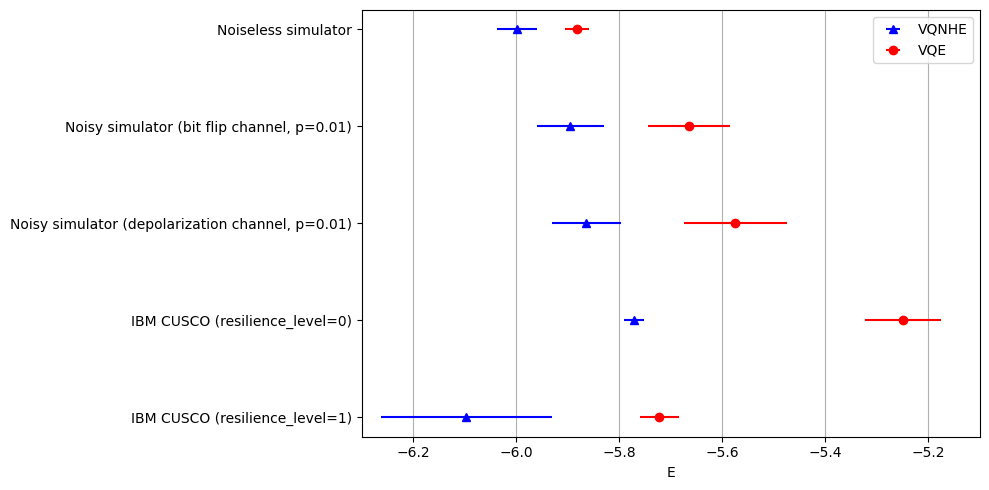

In [342]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data to mimic the plot
# Assuming there are two energy levels for each of the three categories
categories = ['Noiseless simulator', 'Noisy simulator (bit flip channel, p=0.01)', 'Noisy simulator (depolarization channel, p=0.01)',
              'IBM CUSCO (resilience_level=0)', 'IBM CUSCO (resilience_level=1)']
methods = ['VQNHE', 'VQE']
energies = {
    'Noiseless simulator':                                {'VQNHE': (np.mean(vqnhe_noiseless), np.sqrt(np.var(vqnhe_noiseless))),'VQE': (np.mean(vqe_noiseless), np.sqrt(np.var(vqe_noiseless)))},
    'Noisy simulator (bit flip channel, p=0.01)':         {'VQNHE': (np.mean(vqnhe_bitflip_1), np.sqrt(np.var(vqnhe_bitflip_1))), 'VQE': (np.mean(vqe_bitflip_1), np.sqrt(np.var(vqe_bitflip_1)))},
    'Noisy simulator (depolarization channel, p=0.01)':   {'VQNHE': (np.mean(vqnhe_depolarization_1), np.sqrt(np.var(vqnhe_depolarization_1))), 'VQE': (np.mean(vqe_depolarization_1), np.sqrt(np.var(vqe_depolarization_1)))},
    'IBM CUSCO (resilience_level=0)':                     {'VQNHE': (np.mean(vqnhe_cusco_0), np.sqrt(np.var(vqnhe_cusco_0))), 'VQE': (np.mean(vqe_cusco_0), np.sqrt(np.var(vqe_cusco_0)))},
    'IBM CUSCO (resilience_level=1)':                     {'VQNHE': (np.mean(vqnhe_cusco_1), np.sqrt(np.var(vqnhe_cusco_1))), 'VQE': (np.mean(vqe_cusco_1), np.sqrt(np.var(vqe_cusco_1)))},
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the data
for i, category in enumerate(categories):
    for j, method in enumerate(methods):
        mean, error = energies[category][method]
        marker = 'o' if method == 'VQE' else '^'
        color = 'red' if method == 'VQE' else 'blue'
        ax.errorbar(mean, i, xerr=error, fmt=marker, color=color, label=method if i == 0 else "")

# Customizing the plot
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.invert_yaxis()  # Invert y-axis to match the uploaded image
ax.set_xlabel('E')
ax.xaxis.grid(True)  # Add a grid on x-axis
ax.set_xlim(-6.30, -5.10)  # Set the limit for x-axis to match the uploaded image

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

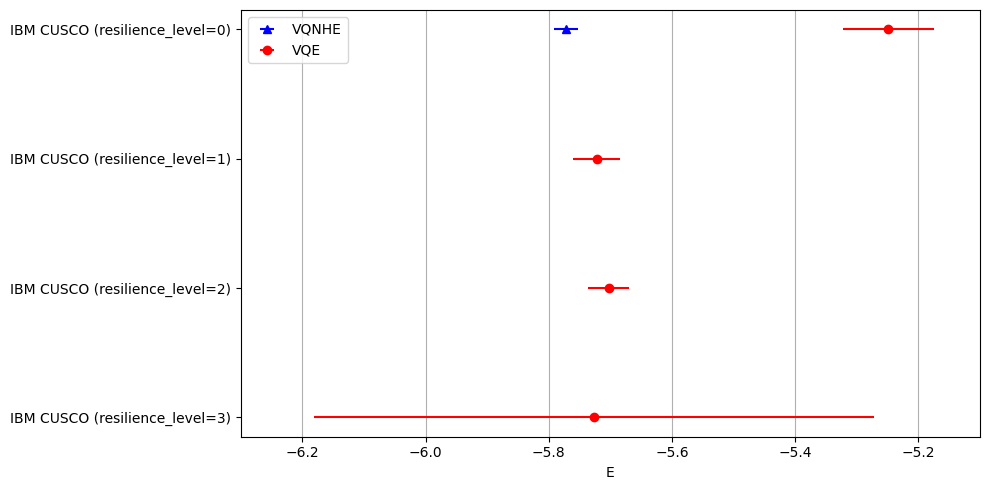

In [344]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data to mimic the plot
# Assuming there are two energy levels for each of the three categories
categories = ['IBM CUSCO (resilience_level=0)', 'IBM CUSCO (resilience_level=1)', 'IBM CUSCO (resilience_level=2)', 'IBM CUSCO (resilience_level=3)']
methods = ['VQNHE', 'VQE']
energies = {
    'IBM CUSCO (resilience_level=0)': {'VQNHE': (np.mean(vqnhe_cusco_0), np.sqrt(np.var(vqnhe_cusco_0))), 'VQE': (np.mean(vqe_cusco_0), np.sqrt(np.var(vqe_cusco_0)))},
    'IBM CUSCO (resilience_level=1)': {'VQNHE': (0, 0), 'VQE': (np.mean(vqe_cusco_1), np.sqrt(np.var(vqe_cusco_1)))},
    'IBM CUSCO (resilience_level=2)': {'VQNHE': (0, 0), 'VQE': (np.mean(vqe_cusco_2), np.sqrt(np.var(vqe_cusco_2)))},
    'IBM CUSCO (resilience_level=3)': {'VQNHE': (0, 0), 'VQE': (np.mean(vqe_cusco_3), np.sqrt(np.var(vqe_cusco_3)))},
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the data
for i, category in enumerate(categories):
    for j, method in enumerate(methods):
        mean, error = energies[category][method]
        marker = 'o' if method == 'VQE' else '^'
        color = 'red' if method == 'VQE' else 'blue'
        ax.errorbar(mean, i, xerr=error, fmt=marker, color=color, label=method if i == 0 else "")

# Customizing the plot
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.invert_yaxis()  # Invert y-axis to match the uploaded image
ax.set_xlabel('E')
ax.xaxis.grid(True)  # Add a grid on x-axis
ax.set_xlim(-6.30, -5.10)  # Set the limit for x-axis to match the uploaded image

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()